#Can you identify fraudulent transactions?
---
You’ve just been invited to interview with the machine learning team at a large financial institution. Their job is to find fraud, waste, and abuse in their payment stream. You have been presented with a sample dataset of transactions and a holdout set, your job is to walk through your process of exploring the data, building model(s), and evaluating them. Your target variable is called EVENT_LABEL and contains a label "legit" or "fraud". There is a data dictionary at the end of this project.

You will train and evaluate three different models.

- Logistic Regression: Serves as a baseline for performance comparison.
- Random Forest: An ensemble method known for its robustness and ability to handle complex data structures.
- Gradient Boosting Machine (GBM) OR XGBoost: Advanced ensemble techniques known for their predictive power.

Your write up should include 3-4 insights, 2-3 recommendations AND address the following:

- The Firm believes that email domain and billing postal code is an important predictor, your write up should discuss why or why not.
- Finally, the firm wants to operate at a 5% false positive rate, how can they do that? based on your best performing model what is the rule with predicted probably of fraud threshold that will give them a 5% false positive rate, what is the recall and precision at that threshold? what does it mean to operate at 5% false positive rate?
- Firm would like to understand in “plain language” the difference between Random Forest and Gradient Boosting; and how they can operate at a 5% False positive rate. For example, what does it mean to operate at 5% false positive rate?

What to Turn in:

- Your Report - Executive Summary + supporting materials see example structure below

- Holdout Sample - take your model and make a prediction!


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import zipfile

# Unzip the file
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/project_2_training.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('')

# Load the dataset
df = pd.read_csv('project_2_training.csv')

# Display the first few rows of the dataframe
df.head()


EVENT_ID  account_age_days  transaction_amt  transaction_adj_amt  \
0   2608000        5774.00000       2172.00000             78.00000   
1    214500        5405.00000       2887.00000             51.00000   
2    294600        6570.00000       2887.00000             56.00000   
3    477060        3865.00000       1591.00000             58.00000   
4   1993100        6625.00000       3297.00000             70.00000   

   historic_velocity      ip_address  \
0         4523.00000   81.237.240.91   
1         4057.00000  160.32.216.178   
2         5602.00000  109.156.235.28   
3         3926.00000  158.152.249.45   
4         6675.00000   167.164.91.31   

                                          user_agent       email_domain  \
0  Mozilla/5.0 (iPod; U; CPU iPhone OS 3_0 like M...         graves.org   
1  Mozilla/5.0 (Macintosh; PPC Mac OS X 10 10_7) ...  howard-madden.com   
2  Mozilla/5.0 (Windows NT 6.2) AppleWebKit/535.2...  walsh-goodwin.com   
3  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  gonzalez-diaz.com   
4  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...  bender-rocha.info   

             phone_number       billing_city  ...  transaction_env  \
0            456-910-9478  South Angelaville  ...                R   
1            269.363.8079    Lake Leslietown  ...                O   
2            366.185.9975        Lake Kendra  ...                C   
3            816-365-8213      East Maryport  ...                G   
4  001-970-935-1735x19620          Yorkburgh  ...                W   

       EVENT_TIMESTAMP   applicant_name            billing_address  \
0  2021-02-21 16:32:23      Kristi Bell          7683 Chavez Curve   
1  2020-12-30 11:36:17      Amanda Bond          628 Cline Streets   
2  2021-03-24 05:34:28    Joanna Walton  268 Ashley Plaza Apt. 416   
3  2021-10-12 16:24:49  Matthew Johnson          8377 Jacob Course   
4  2021-06-23 00:05:15   Susan Phillips    401 Christopher Meadows   

   merchant_id  locale tranaction_initiate days_since_last_logon  \
0  882-35-3409   es_VE                   Q              82.00000   
1  453-93-1357  bhb_IN                   S               2.00000   
2  554-51-8940   mi_NZ                   W              43.00000   
3  492-66-7677  yue_HK                   Y              71.00000   
4  468-86-6030   gd_GB                   Q              52.00000   

  inital_amount EVENT_LABEL  
0    4609.00000       legit  
1   12384.00000       legit  
2    9607.00000       legit  
3   10305.00000       legit  
4    4139.00000       legit  

[5 rows x 27 columns]

In [ ]:
print(df.info())
print(f"rows: {df.shape[0]}, columns: {df.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   EVENT_ID               125000 non-null  int64  
 1   account_age_days       125000 non-null  float64
 2   transaction_amt        125000 non-null  float64
 3   transaction_adj_amt    125000 non-null  float64
 4   historic_velocity      125000 non-null  float64
 5   ip_address             124896 non-null  object 
 6   user_agent             124905 non-null  object 
 7   email_domain           124924 non-null  object 
 8   phone_number           124898 non-null  object 
 9   billing_city           124906 non-null  object 
 10  billing_postal         124902 non-null  float64
 11  billing_state          124906 non-null  object 
 12  card_bin               124890 non-null  float64
 13  currency               124906 non-null  object 
 14  cvv                    124898 non-nu

Column names already look clean, so no need to fix the column names. We also have a fair amount of personal/demographic data, which is something that we know in practice should not be used for predicting fraud.

#### Event Label Stats
- 95% of observations are legit
- 5% of observations are fraud
> We should expect to be mostly legit since majority of the original data set has legit observations, but in this case we are curious on figuring out what features/variables actually determine event label (legit or fraud)

In [ ]:
df['EVENT_LABEL'].value_counts(normalize=True).round(2)

legit   0.95000
fraud   0.05000
Name: EVENT_LABEL, dtype: float64

In [ ]:
# Count of Legit and fraud
df['EVENT_LABEL'].value_counts()

legit    118215
fraud      6785
Name: EVENT_LABEL, dtype: int64

In [ ]:
# Load all the necessary packages from the Smote with Pipelines Notebook
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules
from sklearn.model_selection import train_test_split    #- partition train/test split
from sklearn.linear_model import LogisticRegression     #- logistic regression classifier
from sklearn.ensemble import RandomForestClassifier     #- random forest classifier
from sklearn.ensemble import GradientBoostingClassifier #- GBM classfier
from sklearn.neural_network import MLPClassifier        #- multi-layer perceptron

# -- we need these to make our pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc

# -- we need these to evaluate our models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# -- need this to render charts in notebook --
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

---
## Describe the Data

In [ ]:
def df_profile(df, target):

    df = df.copy()

    numeric_features = [ c for c in df.select_dtypes(include = np.number).columns ]
    pd.options.display.float_format = '{:.5f}'.format

    categorical_features = [ c for c in df.select_dtypes(include = "object").columns ]

    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique','mean','min','max']).transpose().reset_index().rename(columns={"index":"feature_name"}).round(4)
    df_s1['count'] = df_s1['count'].astype('int64')
    df_s1['nunique'] = df_s1['nunique'].astype('int64')
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique'] / rowcnt


    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner')

    df_stats = df_stats.sort_values("dtype").reset_index(drop=True)

    df_stats['feature_type'] = "UNKNOWN"
    df_stats.loc[np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats['dtype'] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[df_stats['feature_name'] == target, 'feature_type'] = "TARGET"

    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[df_stats['nunique_pct'] > 0.9, 'feature_warning'] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[df_stats['null_pct'] > 0.2, 'feature_warning'] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats['null_pct'] > 0.5, 'feature_warning'] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[np.logical_and(np.logical_or(df_stats['dtype'] == int, df_stats['dtype'] == float), df_stats['nunique'] <= 20), 'feature_warning'] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"

    return df_stats

dfp = df_profile(df, 'EVENT_LABEL')
dfp

feature_name    dtype   count  nunique          mean        min  \
0                EVENT_ID    int64  125000   125000 1500443.74368   20.00000   
1        account_age_days  float64  125000     6363    4642.45354   -1.00000   
2         transaction_amt  float64  125000     3641    2519.54538   -1.00000   
3     transaction_adj_amt  float64  125000       93      54.14210   -1.00000   
4       historic_velocity  float64  125000     6633    4699.90033   -1.00000   
5   days_since_last_logon  float64  124887      101      49.81432    0.00000   
6          billing_postal  float64  124902    11064   50210.79106  503.00000   
7                card_bin  float64  124890     6321   41813.29049 6040.00000   
8           inital_amount  float64  124891    13999    7999.64274 1000.00000   
9     tranaction_initiate   object  124900       26           NaN        NaN   
10                 locale   object  124885      293           NaN        NaN   
11            merchant_id   object  124911   124904           NaN        NaN   
12        billing_address   object  124889   124884           NaN        NaN   
13         applicant_name   object  124876    84958           NaN        NaN   
14        EVENT_TIMESTAMP   object  124910   124685           NaN        NaN   
15        transaction_env   object  124896       26           NaN        NaN   
16               currency   object  124906        3           NaN        NaN   
17        signature_image   object  124908       26           NaN        NaN   
18                    cvv   object  124898       25           NaN        NaN   
19          billing_state   object  124906       50           NaN        NaN   
20           billing_city   object  124906     8979           NaN        NaN   
21           phone_number   object  124898    11927           NaN        NaN   
22           email_domain   object  124924     6991           NaN        NaN   
23             user_agent   object  124905     8570           NaN        NaN   
24             ip_address   object  124896    13313           NaN        NaN   
25       transaction_type   object  124902       26           NaN        NaN   
26            EVENT_LABEL   object  125000        2           NaN      fraud   

             max  null  not_null  null_pct  nunique_pct feature_type  \
0  2999960.00000     0    125000   0.00000      1.00000      NUMERIC   
1     9119.00000     0    125000   0.00000      0.05090      NUMERIC   
2     4880.00000     0    125000   0.00000      0.02913      NUMERIC   
3       99.00000     0    125000   0.00000      0.00074      NUMERIC   
4     8875.00000     0    125000   0.00000      0.05306      NUMERIC   
5      100.00000   113    124887   0.00090      0.00081      NUMERIC   
6    99950.00000    98    124902   0.00078      0.08851      NUMERIC   
7    67639.00000   110    124890   0.00088      0.05057      NUMERIC   
8    15000.00000   109    124891   0.00087      0.11199      NUMERIC   
9            NaN   100    124900   0.00080      0.00021     CATEGORY   
10           NaN   115    124885   0.00092      0.00234     CATEGORY   
11           NaN    89    124911   0.00071      0.99923     CATEGORY   
12           NaN   111    124889   0.00089      0.99907     CATEGORY   
13           NaN   124    124876   0.00099      0.67966     CATEGORY   
14           NaN    90    124910   0.00072      0.99748     CATEGORY   
15           NaN   104    124896   0.00083      0.00021     CATEGORY   
16           NaN    94    124906   0.00075      0.00002     CATEGORY   
17           NaN    92    124908   0.00074      0.00021     CATEGORY   
18           NaN   102    124898   0.00082      0.00020     CATEGORY   
19           NaN    94    124906   0.00075      0.00040     CATEGORY   
20           NaN    94    124906   0.00075      0.07183     CATEGORY   
21           NaN   102    124898   0.00082      0.09542     CATEGORY   
22           NaN    76    124924   0.00061      0.05593     CATEGORY   
23           NaN    95    124905   0.00076  

Likely predictors are and what we want to avoid predicting on is id, many unique values under a column

## Exploratory Data Analysis

In [ ]:
# Null Analysis
df.isnull().sum()

EVENT_ID                   0
account_age_days           0
transaction_amt            0
transaction_adj_amt        0
historic_velocity          0
ip_address               104
user_agent                95
email_domain              76
phone_number             102
billing_city              94
billing_postal            98
billing_state             94
card_bin                 110
currency                  94
cvv                      102
signature_image           92
transaction_type          98
transaction_env          104
EVENT_TIMESTAMP           90
applicant_name           124
billing_address          111
merchant_id               89
locale                   115
tranaction_initiate      100
days_since_last_logon    113
inital_amount            109
EVENT_LABEL                0
dtype: int64

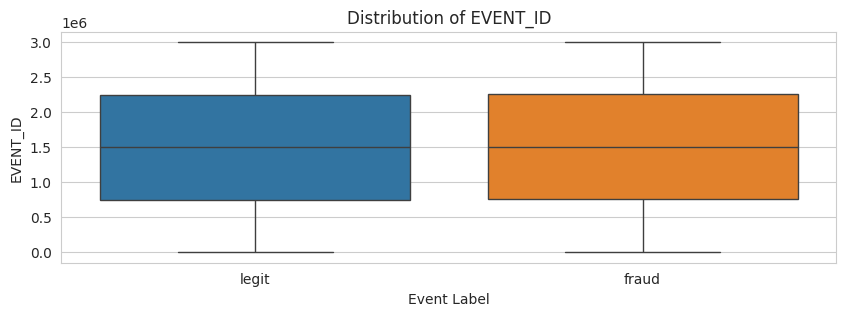

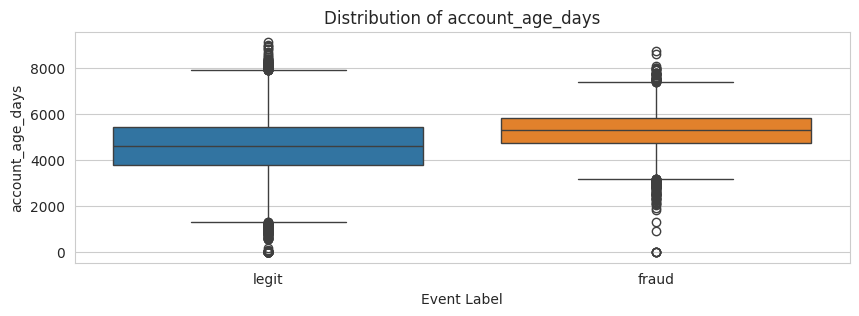

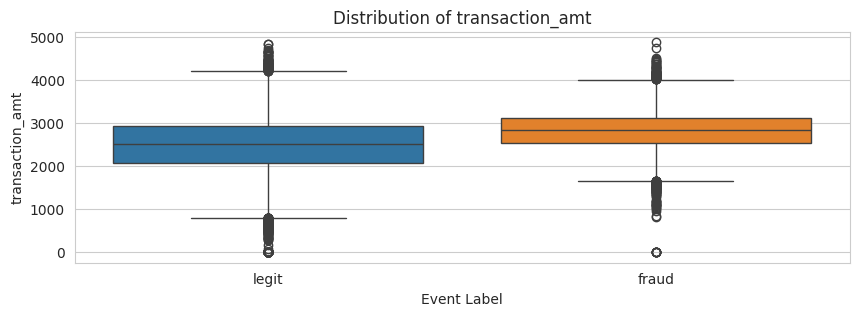

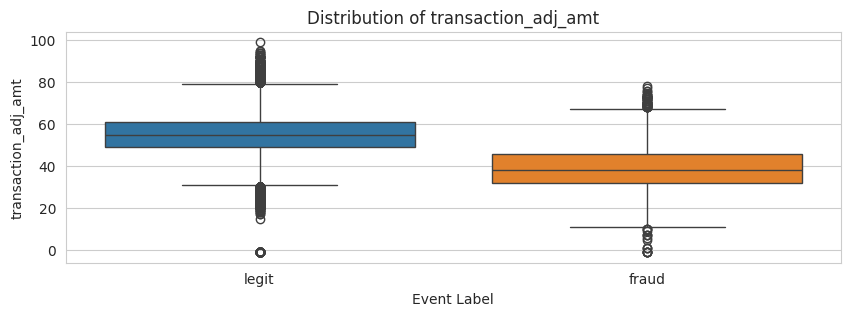

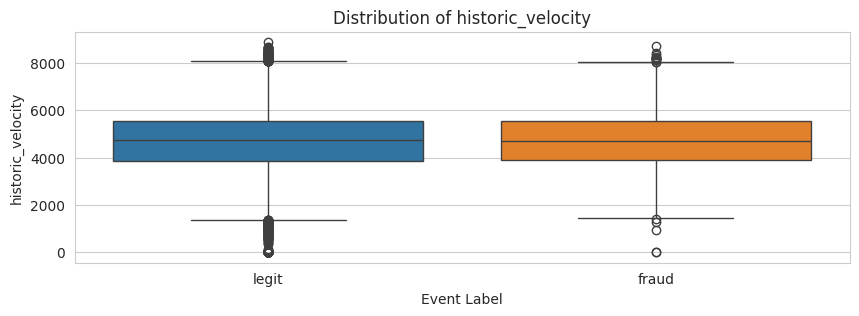

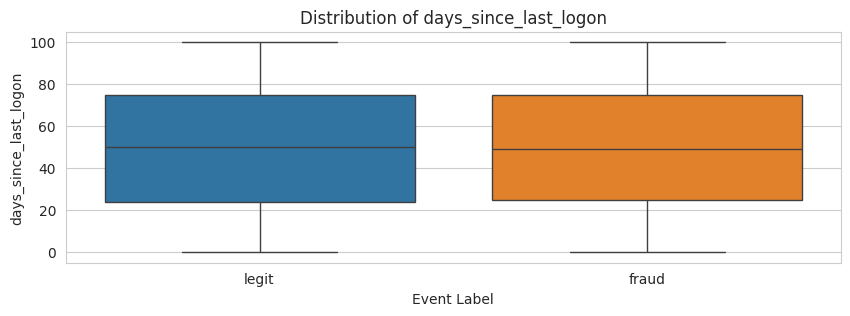

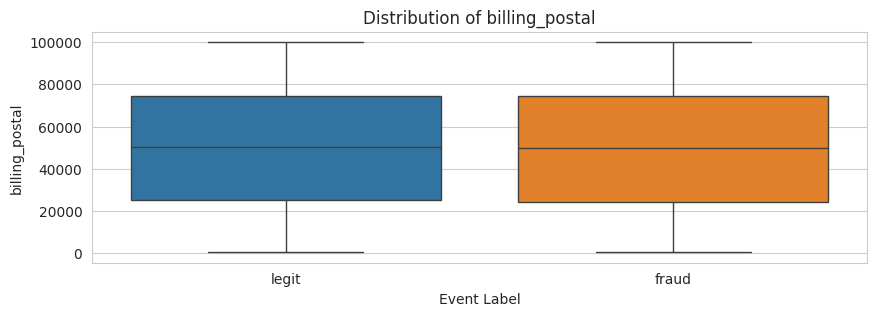

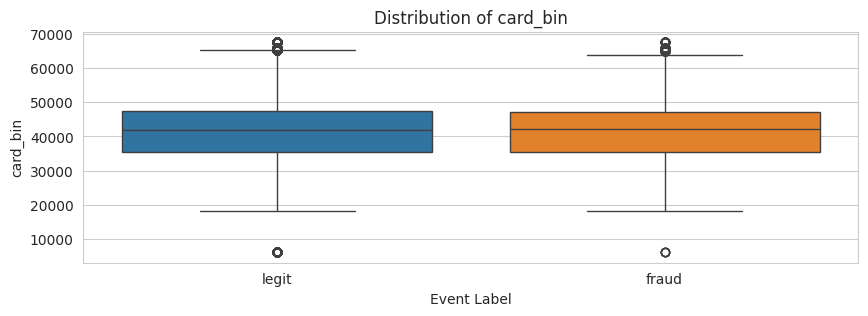

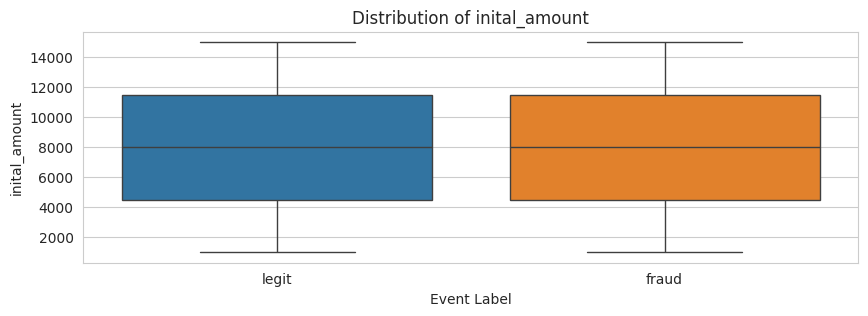

In [ ]:
numeric_features = dfp.query('feature_type == "NUMERIC"')['feature_name'].to_list()
for num_col in numeric_features:
  plt.figure(figsize=(10, 3))
  sns.boxplot(x='EVENT_LABEL', y=num_col, hue = 'EVENT_LABEL', data=df)
  plt.title(f'Distribution of {num_col}')
  plt.xlabel('Event Label')
  plt.ylabel(num_col)
  #plt.show()

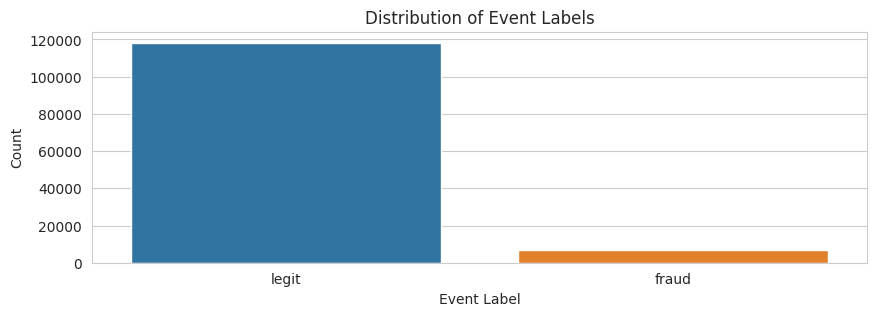

In [ ]:
plt.figure(figsize=(10, 3))
sns.countplot(x='EVENT_LABEL', hue='EVENT_LABEL', data=df)
plt.title(f'Distribution of Event Labels')
plt.xlabel('Event Label')
plt.ylabel('Count')
plt.show()

### Explore Likely Predictors


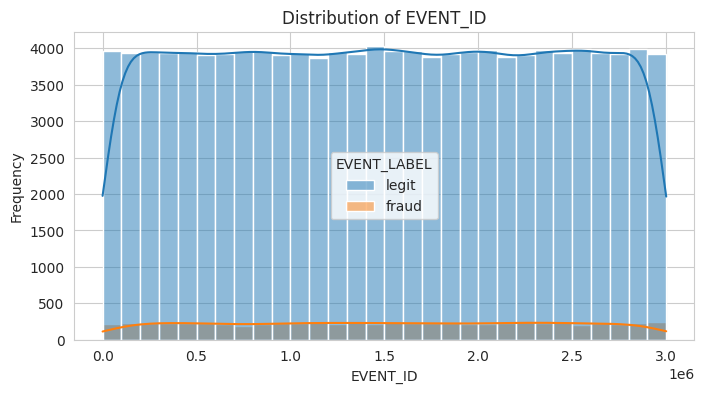

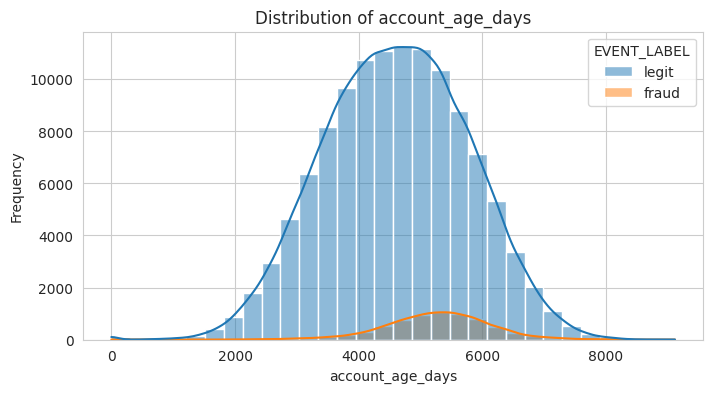

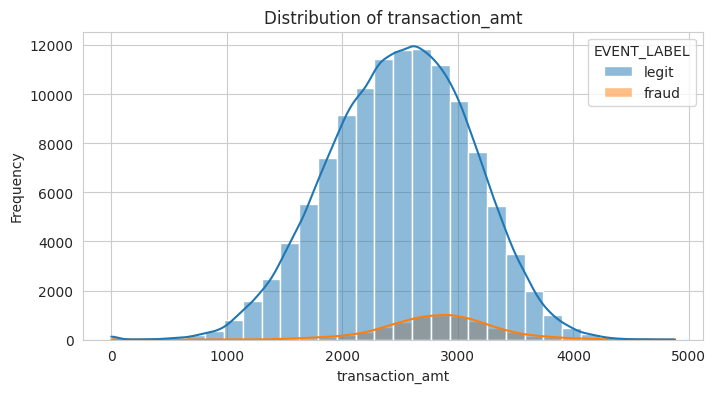

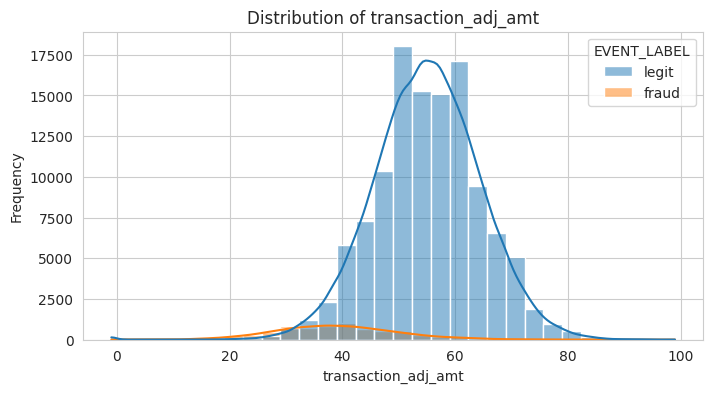

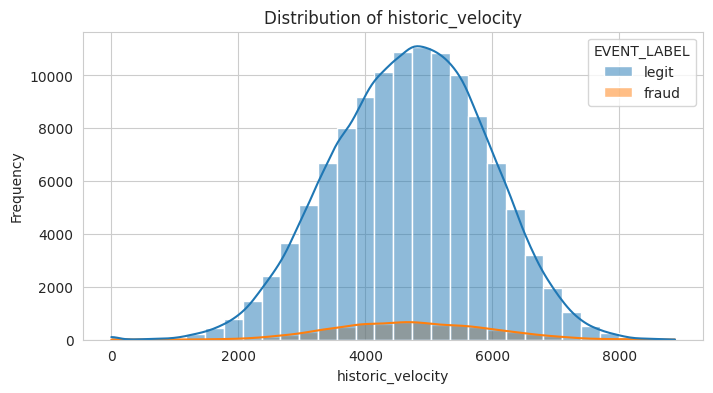

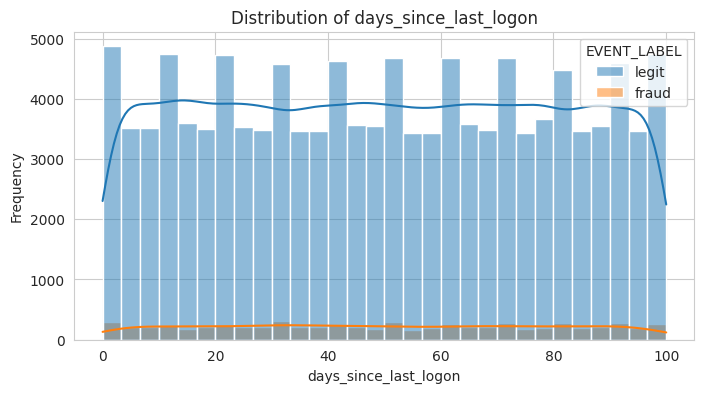

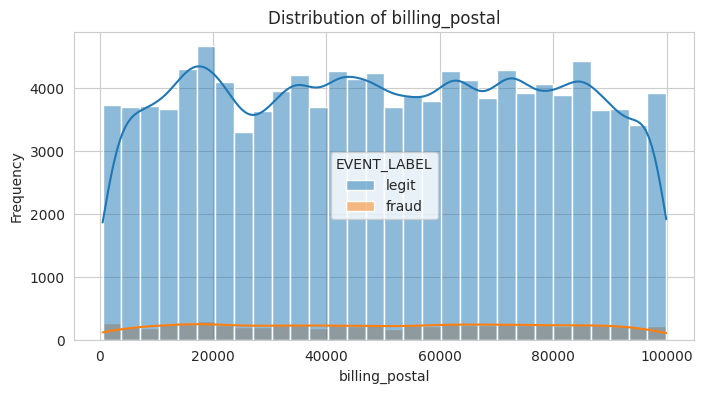

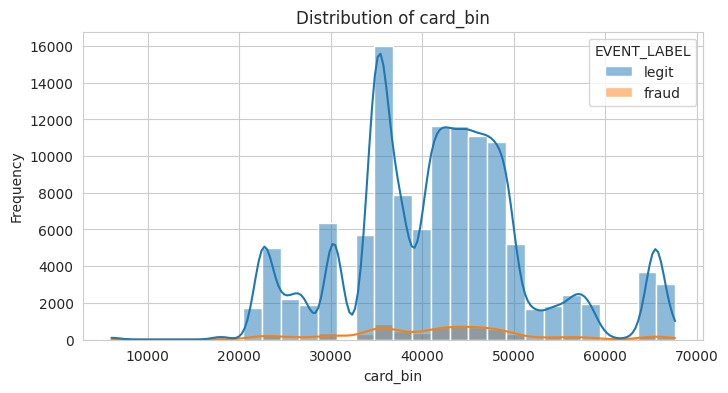

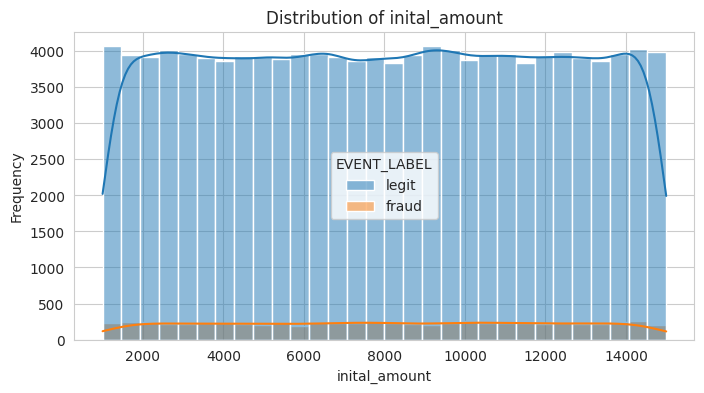

In [ ]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data= df, x=col, hue="EVENT_LABEL", kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


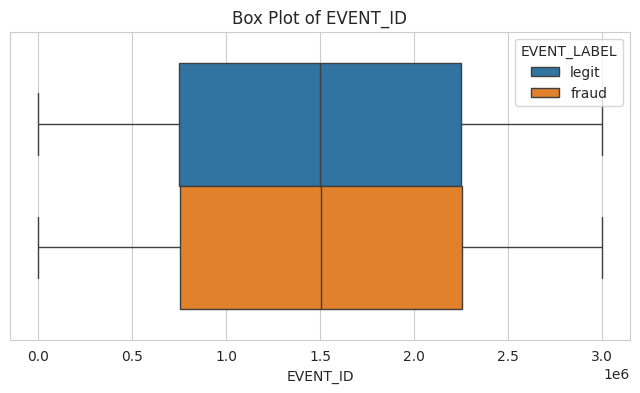

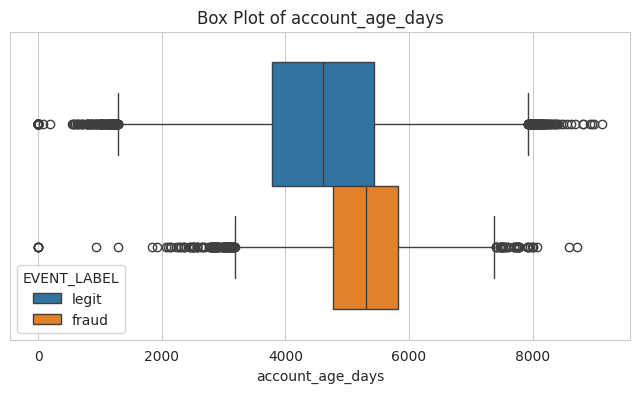

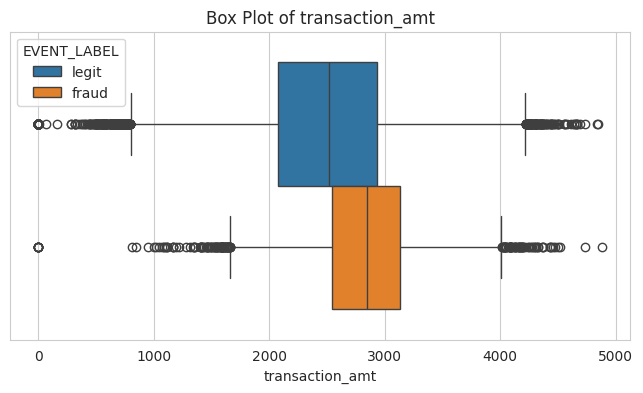

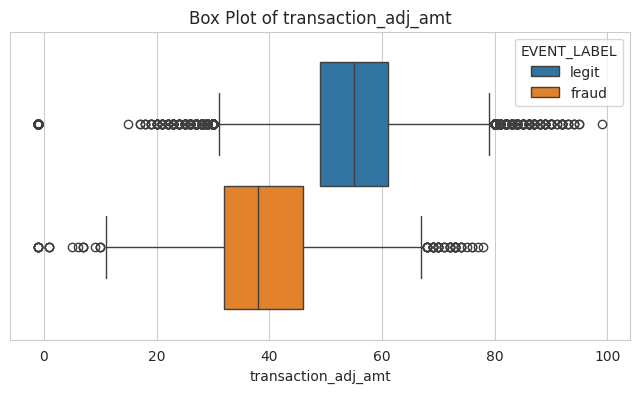

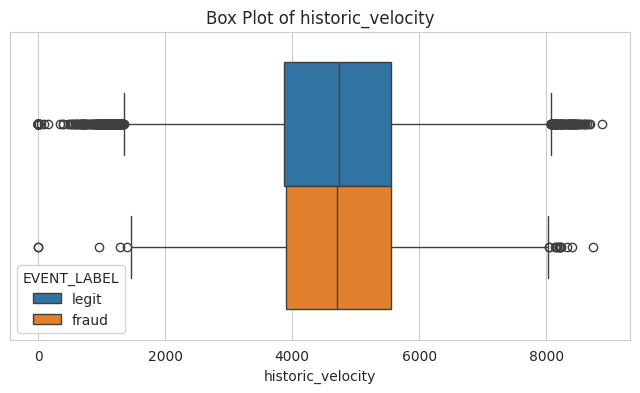

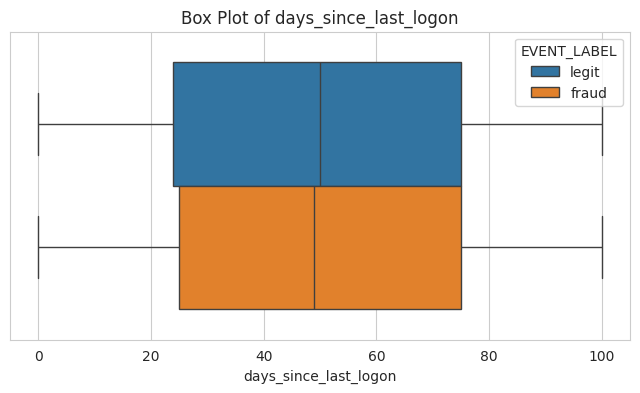

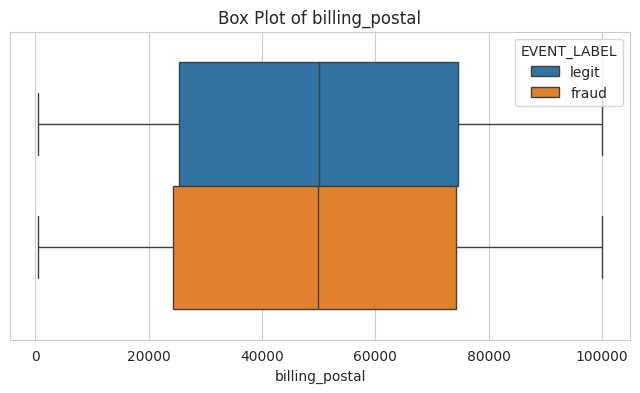

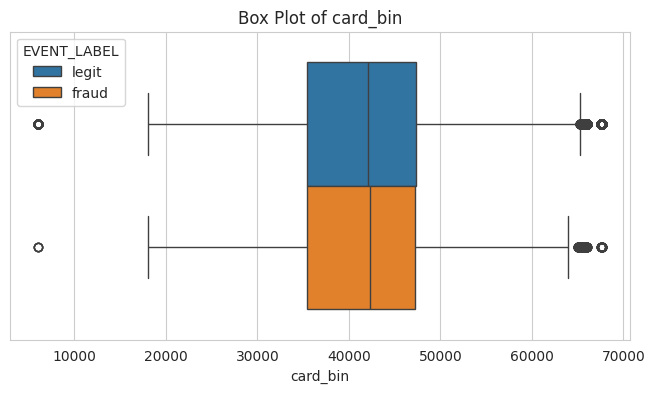

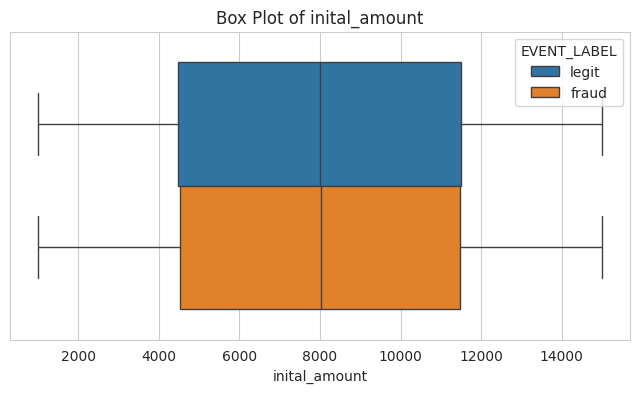

In [ ]:
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data= df, x=col, hue="EVENT_LABEL")
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()


In [ ]:
# Compute the correlation matrix
#corr = df[numeric_features.corr()]

# Generate a heatmap
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
#plt.title('Correlation Matrix of Numeric Features')
#plt.show()


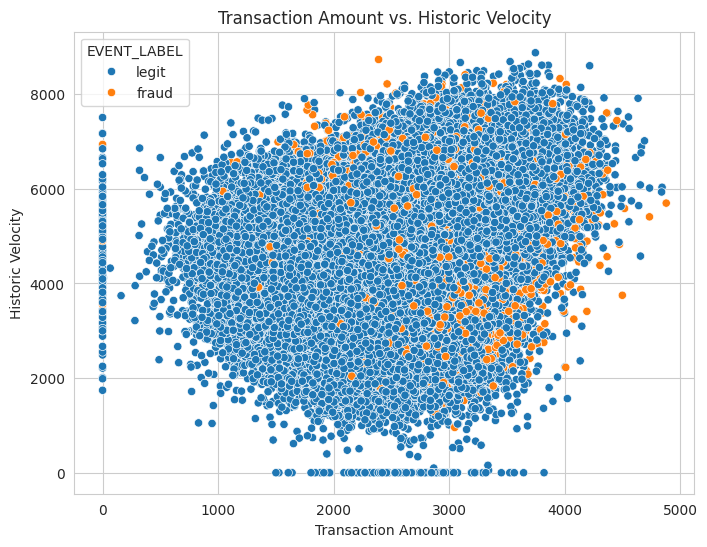

In [ ]:
# Example scatter plot between 'transaction_amt' and 'historic_velocity'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='transaction_amt', y='historic_velocity', hue='EVENT_LABEL')
plt.title('Transaction Amount vs. Historic Velocity')
plt.xlabel('Transaction Amount')
plt.ylabel('Historic Velocity')
plt.show()


### Good or Bad Predictors? Email Domain and Billing Postal
1. Email Domain
2. Billing Postal

In [ ]:
print(f"How Many Unique Email Domains Are There?", df['email_domain'].nunique())

How Many Unique Email Domains Are There? 6991


In [ ]:
# Find the 10 most common email domains and their event label
df[['email_domain', 'EVENT_LABEL']].value_counts().nlargest(10)

email_domain        EVENT_LABEL
freeman-adams.com   legit          59
cochran.biz         legit          56
boyle-murray.com    legit          55
solis.com           legit          55
lane.info           legit          55
gutierrez-ryan.com  legit          54
howard-holt.org     legit          54
luna-walker.com     legit          54
calhoun.org         legit          53
walker.com          legit          52
dtype: int64

In [ ]:
# Find the 10 least common email domains and their event label
df[['email_domain', 'EVENT_LABEL']].value_counts().nsmallest(10)

email_domain             EVENT_LABEL
nguyen-rich.com          fraud          1
martinez-randall.com     legit          1
martinez-richardson.com  fraud          1
cantrell-dean.com        legit          1
cannon.com               legit          1
brown-stanley.biz        fraud          1
brown-taylor.com         fraud          1
martinez-west.com        legit          1
nguyen-ramirez.com       legit          1
villanueva.org           fraud          1
dtype: int64

In [ ]:
# Email Domains and how many are fraud and legit
df.groupby('EVENT_LABEL')['email_domain'].agg(['count']).reset_index()

EVENT_LABEL   count
0       fraud    6783
1       legit  118141

In [ ]:
# Let's create a new dataframe where we groupby event label and email domain to see which are fraud and which are legit
email_counts = df.groupby(['EVENT_LABEL', 'email_domain']).size().reset_index(name='count')

# Filter for fraud and legit labels
fraud_counts = email_counts[email_counts['EVENT_LABEL'] == 'fraud']
legit_counts = email_counts[email_counts['EVENT_LABEL'] == 'legit']

# Sort by count in descending order
fraud_counts_sorted = fraud_counts.sort_values(by='count', ascending=False)
legit_counts_sorted = legit_counts.sort_values(by='count', ascending=False)

print("Fraudulent Email Domains (Descending Order):")
print(fraud_counts_sorted)

print("\nLegitimate Email Domains (Descending Order):")
print(legit_counts_sorted)

Fraudulent Email Domains (Descending Order):
     EVENT_LABEL         email_domain  count
636        fraud             cruz.net     11
2238       fraud       pham-stone.com     10
77         fraud            arias.biz      9
189        fraud             beck.biz      9
2026       fraud   murphy-sanders.org      9
...          ...                  ...    ...
793        fraud   espinoza-yoder.net      1
794        fraud         espinoza.biz      1
2230       fraud  petersen-bailey.org      1
2229       fraud           peters.com      1
1319       fraud     hoover-kelly.com      1

[3197 rows x 3 columns]

Legitimate Email Domains (Descending Order):
     EVENT_LABEL         email_domain  count
5131       legit    freeman-adams.com     59
4362       legit          cochran.biz     56
6620       legit            lane.info     55
3794       legit     boyle-murray.com     55
9135       legit            solis.com     55
...          ...                  ...    ...
9538       legit  vasquez-dan

In [ ]:
# Value Counts and Ranges of the legits and frauds
print(f"Fraud Ranges:\n{fraud_counts_sorted['count'].value_counts()}")
print(f"\nLegit Ranges:\n{legit_counts_sorted['count'].value_counts()}")

Fraud Ranges:
1     1384
2      823
3      522
4      268
5      127
6       49
7       14
8        5
9        3
11       1
10       1
Name: count, dtype: int64

Legit Ranges:
1     767
2     445
3     348
4     246
5     223
6     187
7     177
9     171
29    166
10    165
8     157
13    149
23    146
28    144
16    140
11    138
26    137
15    136
25    134
12    133
34    133
27    132
32    131
33    131
31    130
30    130
18    128
19    128
22    124
14    124
36    123
20    120
21    118
17    116
24    115
37    114
35    104
38     99
39     81
40     78
41     59
42     48
44     44
43     36
45     26
46     15
48     12
47     11
49      7
50      7
51      4
52      3
54      3
55      3
56      1
53      1
59      1
Name: count, dtype: int64


Billing Postal

In [ ]:
print(f"How Many Unique Billing Postal Codes Are There?", df['billing_postal'].nunique())

How Many Unique Billing Postal Codes Are There? 11064


In [ ]:
# Find the 10 most common billing postal codes and their event label
df[['billing_postal', 'EVENT_LABEL']].value_counts().nlargest(10)

billing_postal  EVENT_LABEL
85441.00000     legit          36
15732.00000     legit          36
95710.00000     legit          36
97225.00000     legit          36
84885.00000     legit          35
18002.00000     legit          34
50225.00000     legit          34
85088.00000     legit          34
75955.00000     legit          33
64804.00000     legit          33
dtype: int64

In [ ]:
# Find the 10 least common billing postal codes and their event label
df[['billing_postal', 'EVENT_LABEL']].value_counts().nsmallest(10)

billing_postal  EVENT_LABEL
90095.00000     fraud          1
90094.00000     fraud          1
51979.00000     fraud          1
90073.00000     fraud          1
51831.00000     fraud          1
61790.00000     legit          1
60067.00000     fraud          1
61790.00000     fraud          1
49676.00000     fraud          1
13192.00000     fraud          1
dtype: int64

In [ ]:
# Billing Postal Codes and how many are fraud and legit
df.groupby('EVENT_LABEL')['billing_postal'].agg(['count']).reset_index()

EVENT_LABEL   count
0       fraud    6778
1       legit  118124

In [ ]:
# Let's create a new dataframe where we groupby event label and billing postal to see which are fraud and which are legit
billing_postal_counts = df.groupby(['EVENT_LABEL', 'billing_postal']).size().reset_index(name='count')

# Filter for fraud and legit labels
fraud_counts = billing_postal_counts[billing_postal_counts['EVENT_LABEL'] == 'fraud']
legit_counts = billing_postal_counts[billing_postal_counts['EVENT_LABEL'] == 'legit']

# Sort by count in descending order
fraud_counts_sorted = fraud_counts.sort_values(by='count', ascending=False)
legit_counts_sorted = legit_counts.sort_values(by='count', ascending=False)

print("Fraudulent Billing Postal Codes (Descending Order):")
print(fraud_counts_sorted)

print("\nLegitimate Billing Postal Codes (Descending Order):")
print(legit_counts_sorted)

Fraudulent Billing Postal Codes (Descending Order):
     EVENT_LABEL  billing_postal  count
3661       fraud     78349.00000      7
2541       fraud     56016.00000      6
1837       fraud     40620.00000      6
2614       fraud     57343.00000      6
2890       fraud     62881.00000      6
...          ...             ...    ...
2434       fraud     53730.00000      1
2435       fraud     53768.00000      1
2436       fraud     53780.00000      1
2437       fraud     53782.00000      1
2333       fraud     51186.00000      1

[4666 rows x 3 columns]

Legitimate Billing Postal Codes (Descending Order):
      EVENT_LABEL  billing_postal  count
15298       legit     97225.00000     36
6315        legit     15732.00000     36
14049       legit     85441.00000     36
15139       legit     95710.00000     36
13981       legit     84885.00000     35
...           ...             ...    ...
13200       legit     77902.00000      1
14656       legit     90944.00000      1
14655       legit    

In [ ]:
# Value Counts and Ranges of the legits and frauds
print(f"Fraud Ranges:\n{fraud_counts_sorted['count'].value_counts()}")
print(f"\Legit Ranges:\n{legit_counts_sorted['count'].value_counts()}")

Fraud Ranges:
1    3127
2    1105
3     331
4      73
5      25
6       4
7       1
Name: count, dtype: int64
\Legit Ranges:
1     1338
2      841
3      621
4      499
6      443
5      436
14     428
17     421
15     409
18     397
16     393
7      382
19     381
8      376
13     371
11     368
12     368
10     363
9      358
20     348
21     275
22     256
23     226
24     180
25     130
26     106
27      89
28      49
29      34
30      26
31      19
33       7
36       4
32       3
34       3
35       1
Name: count, dtype: int64


---
# Following the cookbook recipe with building a predictive machine model!
- Here I am going run through steps 1-6, except for Parameter Tuning just to show the difference between a baseline performance and the performance when we implement hyper parameterization for predictive performance. Also, more importantly we would like to a demonstration of how this process actually works in practice!


1. Train and Split Data
2. Preprocess Data with Pipelines for handling nulls and scaling
3. Model Training
4. Parameter Tuning
5. Feature Selection
6. Performance Metrics
7. Feature Importance Analysis


In [ ]:
# Select Important Features
df = df[['billing_state','currency','cvv','signature_image',
        'transaction_type','transaction_env','locale',
        'tranaction_initiate','account_age_days', 'transaction_amt',
        'historic_velocity','days_since_last_logon','inital_amount', 'EVENT_LABEL']]

---
## Partition the Data (Split: 70% training and 30% testing)
- When making predictions we must convert legit and fraud into values.
> Legit is 0
> Fraud is 1

In [ ]:
## Convert event label to a 0 / 1
df['EVENT_LABEL'] = df['EVENT_LABEL'].map({'legit': 0, 'fraud': 1})
df['EVENT_LABEL'].value_counts(normalize=True).round(2)

0   0.95000
1   0.05000
Name: EVENT_LABEL, dtype: float64

#### Train/Test Split

In [ ]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


In [ ]:
# How many rows in training data and compare it to the original data set
print(f"Rows in Training Data: {train.shape[0]}")
print(f"Rows in Original Data frame: {df.shape[0]}")
print(f"Difference in Rows: {df.shape[0]-train.shape[0]}")

Rows in Training Data: 87500
Rows in Original Data frame: 125000
Difference in Rows: 37500


In [ ]:
# preview the training data
train.head()

billing_state currency cvv signature_image transaction_type  \
65423      Michigan      usd   D               U                C   
3587   Rhode Island      cad   W               U                X   
74674     Minnesota      cad   X               U                X   
12575      New York      cad   X               H                H   
32764       Montana      cad   I               G                F   

      transaction_env locale tranaction_initiate  account_age_days  \
65423               D  zh_HK                   D        5897.00000   
3587                D  ar_EG                   Z        7207.00000   
74674               D  lv_LV                   U        6369.00000   
12575               C  af_ZA                   W        6043.00000   
32764               W  yi_US                   M        4419.00000   

       transaction_amt  historic_velocity  days_since_last_logon  \
65423       3452.00000         4625.00000               91.00000   
3587        3628.00000         7319.00000               60.00000   
74674       2895.00000         5752.00000               24.00000   
12575       2869.00000         7301.00000               14.00000   
32764       2103.00000         3570.00000               58.00000   

       inital_amount  EVENT_LABEL  
65423     3376.00000            0  
3587      1963.00000            0  
74674     6805.00000            0  
12575     2765.00000            0  
32764     9167.00000            0

In [ ]:
dfp_2 = df_profile(df, 'EVENT_LABEL')
dfp_2

feature_name    dtype   count  nunique       mean        min  \
0             EVENT_LABEL    int64  125000        2    0.05430    0.00000   
1        account_age_days  float64  125000     6363 4642.45350   -1.00000   
2         transaction_amt  float64  125000     3641 2519.54540   -1.00000   
3       historic_velocity  float64  125000     6633 4699.90030   -1.00000   
4   days_since_last_logon  float64  124887      101   49.81430    0.00000   
5           inital_amount  float64  124891    13999 7999.64270 1000.00000   
6           billing_state   object  124906       50        NaN        NaN   
7                currency   object  124906        3        NaN        NaN   
8                     cvv   object  124898       25        NaN        NaN   
9         signature_image   object  124908       26        NaN        NaN   
10       transaction_type   object  124902       26        NaN        NaN   
11        transaction_env   object  124896       26        NaN        NaN   
12                 locale   object  124885      293        NaN        NaN   
13    tranaction_initiate   object  124900       26        NaN        NaN   

           max  null  not_null  null_pct  nunique_pct feature_type  \
0      1.00000     0    125000   0.00000      0.00002       TARGET   
1   9119.00000     0    125000   0.00000      0.05090      NUMERIC   
2   4880.00000     0    125000   0.00000      0.02913      NUMERIC   
3   8875.00000     0    125000   0.00000      0.05306      NUMERIC   
4    100.00000   113    124887   0.00090      0.00081      NUMERIC   
5  15000.00000   109    124891   0.00087      0.11199      NUMERIC   
6          NaN    94    124906   0.00075      0.00040     CATEGORY   
7          NaN    94    124906   0.00075      0.00002     CATEGORY   
8          NaN   102    124898   0.00082      0.00020     CATEGORY   
9          NaN    92    124908   0.00074      0.00021     CATEGORY   
10         NaN    98    124902   0.00078      0.00021     CATEGORY   
11         NaN   104    124896   0.00083      0.00021     CATEGORY   
12         NaN   115    124885   0.00092      0.00234     CATEGORY   
13         NaN   100    124900   0.00080      0.00021     CATEGORY   

                                   feature_warning  
0   LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY  
1                                       NO WARNING  
2                                       NO WARNING  
3                                       NO WARNING  
4                                       NO WARNING  
5                                       NO WARNING  
6                                       NO WARNING  
7                                       NO WARNING  
8                                       NO WARNING  
9                                       NO WARNING  
10                                      NO WARNING  
11                                      NO WARNING  
12                                      NO WARNING  
13                                      NO WARNING

In [ ]:
# 1. Split features into categorical, numeric, and target
numeric_features =  dfp_2.query('feature_type == "NUMERIC"')['feature_name'].to_list()
print(f"Numeric Features:", numeric_features)
categorical_features = dfp_2.query('feature_type == "CATEGORY"')['feature_name'].to_list()
print(f"Categorical Features:", categorical_features)
target_feature = dfp_2.query('feature_type == "TARGET"')['feature_name'].to_list()
print(f"Target Feature:", target_feature)

Numeric Features: ['account_age_days', 'transaction_amt', 'historic_velocity', 'days_since_last_logon', 'inital_amount']
Categorical Features: ['billing_state', 'currency', 'cvv', 'signature_image', 'transaction_type', 'transaction_env', 'locale', 'tranaction_initiate']
Target Feature: ['EVENT_LABEL']


In [ ]:
# preview the training data with the numeric features
train[numeric_features].head()

account_age_days  transaction_amt  historic_velocity  \
65423        5897.00000       3452.00000         4625.00000   
3587         7207.00000       3628.00000         7319.00000   
74674        6369.00000       2895.00000         5752.00000   
12575        6043.00000       2869.00000         7301.00000   
32764        4419.00000       2103.00000         3570.00000   

       days_since_last_logon  inital_amount  
65423               91.00000     3376.00000  
3587                60.00000     1963.00000  
74674               24.00000     6805.00000  
12575               14.00000     2765.00000  
32764               58.00000     9167.00000

In [ ]:
# preview the training data with categorical features
train[categorical_features].head()

billing_state currency cvv signature_image transaction_type  \
65423      Michigan      usd   D               U                C   
3587   Rhode Island      cad   W               U                X   
74674     Minnesota      cad   X               U                X   
12575      New York      cad   X               H                H   
32764       Montana      cad   I               G                F   

      transaction_env locale tranaction_initiate  
65423               D  zh_HK                   D  
3587                D  ar_EG                   Z  
74674               D  lv_LV                   U  
12575               C  af_ZA                   W  
32764               W  yi_US                   M

In [ ]:
# preview the legit and fraud results
train[target_feature]

EVENT_LABEL
65423             0
3587              0
74674             0
12575             0
32764             0
...             ...
124363            0
48452             0
56944             1
105881            0
78073             0

[87500 rows x 1 columns]

### Preprocess the data with Pipelines and splitting features into categorical and numeric
- For handling nulls, I will use the KNN Imputer for Numeric Data and Simple Imputer for Text data and then use One Hot Encoder to convert text data into numeric data (think of dummizying variables)


 ### Try the cookbook recipe with preprocessing and fitting numeric data

In [ ]:
# -- define pipelines --

numerical_pipe = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scale', StandardScaler())])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # we could also do strategy='constant', fill_value='missing'
     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessing = ColumnTransformer(transformers=[
   #('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)])

log_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',LogisticRegression(random_state=0, max_iter=150))
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',RandomForestClassifier(n_estimators=10))
])

gbm_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',GradientBoostingClassifier(n_estimators=20))
])

log_pipeline.fit(train[numeric_features], train['EVENT_LABEL'])
rf_pipeline.fit(train[numeric_features], train['EVENT_LABEL'])
gbm_pipeline.fit(train[numeric_features], train['EVENT_LABEL'])

print("Training Complete")

Training Complete


### Fitting the preprocessed data
- def plot_model_curves(model_set, X, y):

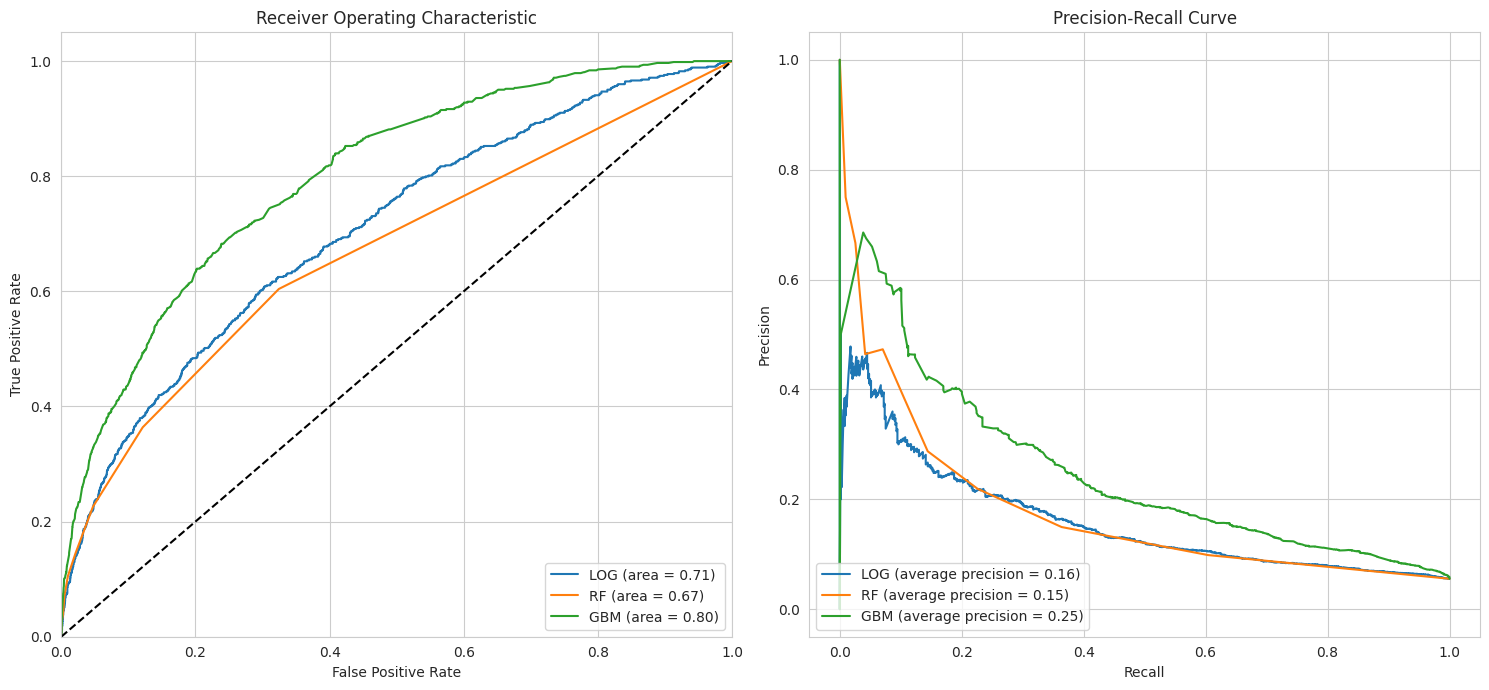

In [ ]:
model_set = {"LOG": log_pipeline,
            "RF": rf_pipeline,
            "GBM": gbm_pipeline}

def plot_model_curves(model_set, X, y):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    plt.figure(figsize=(15, 7))

    # ROC Curve plot
    plt.subplot(1, 2, 1)
    for name, model in model_set.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Get predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # PR Curve plot
    plt.subplot(1, 2, 2)
    for name, model in model_set.items():
        # Get predicted probabilities
        y_score = model.predict_proba(X_test)[:, 1]
        # Compute PR curve and PR area
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        average_precision = average_precision_score(y_test, y_score)
        # Plot
        plt.plot(recall, precision, label=f'{name} (average precision = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Example usage:
model_set = {
    "LOG": log_pipeline, # Logistic Regression Pipeline
    "RF": rf_pipeline,  # Random Forest pipeline
     "GBM": gbm_pipeline  # Gradient Boosting pipeline
 }
plot_model_curves(model_set, test[numeric_features], test['EVENT_LABEL'])


### Variable Importance
- def plot_permutation_importance(model_set, X, y):

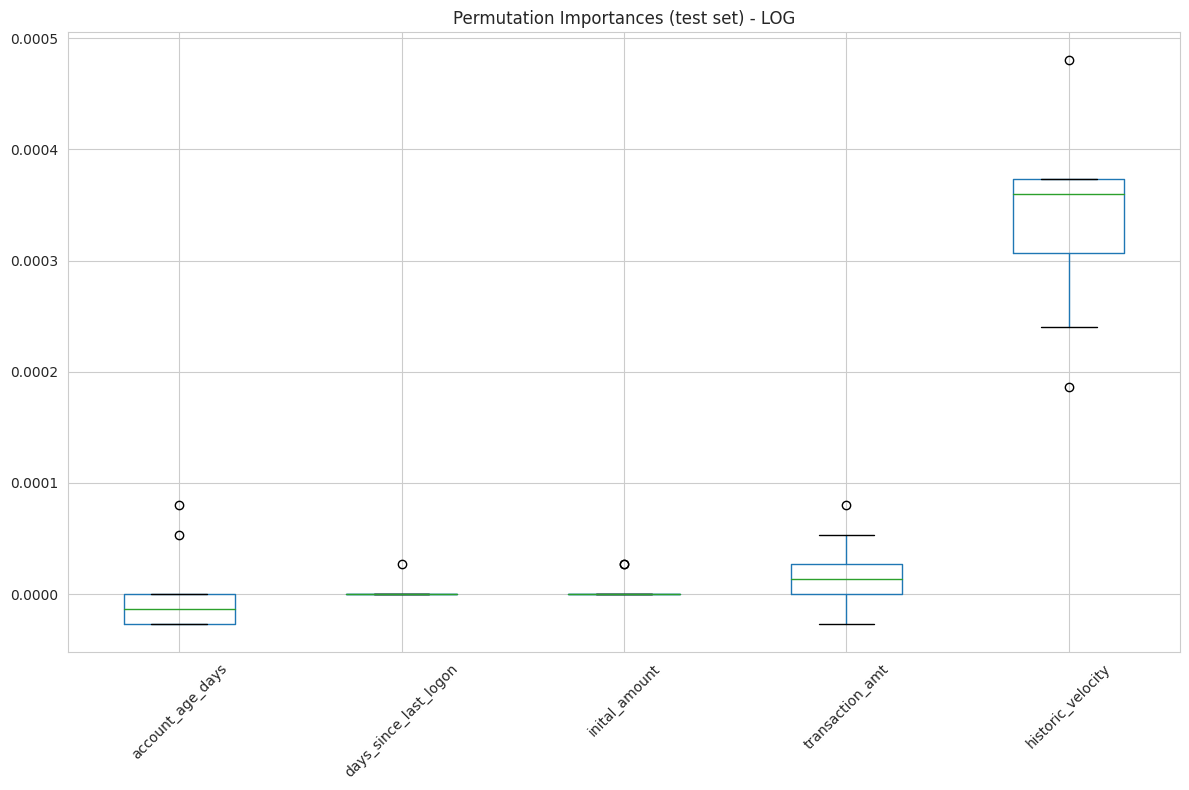

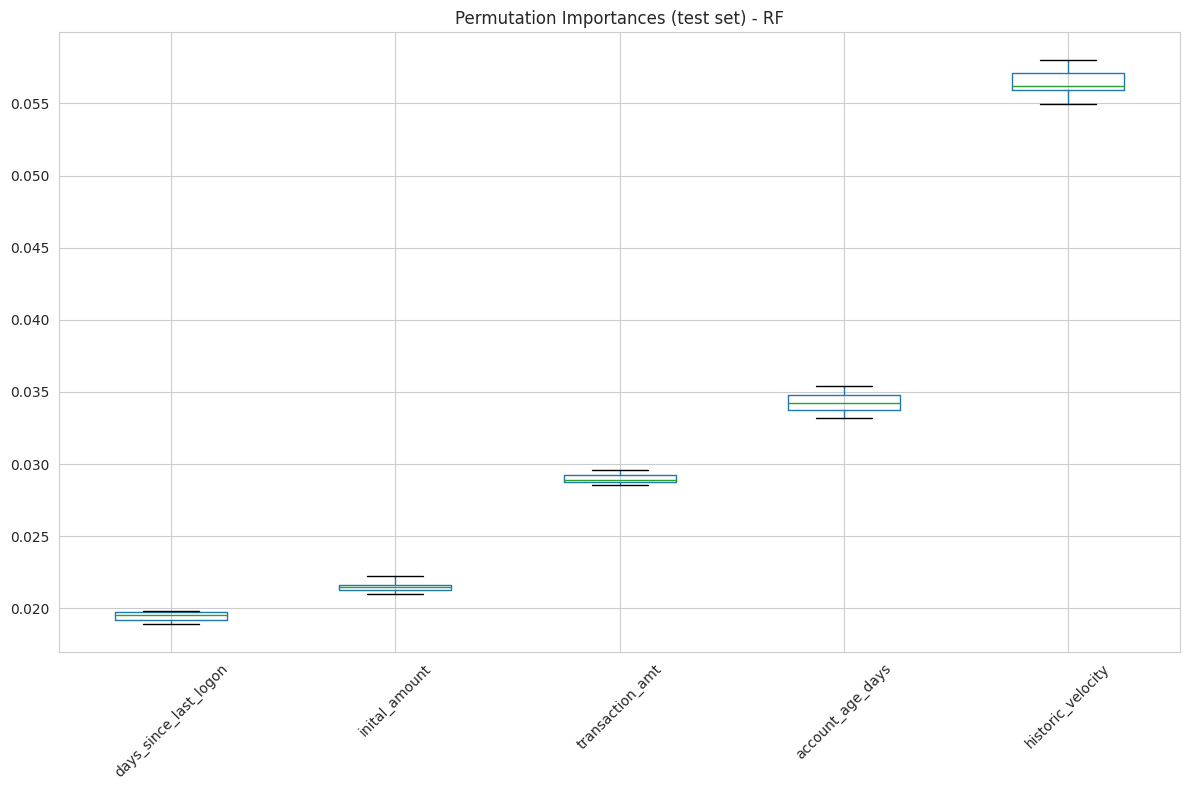

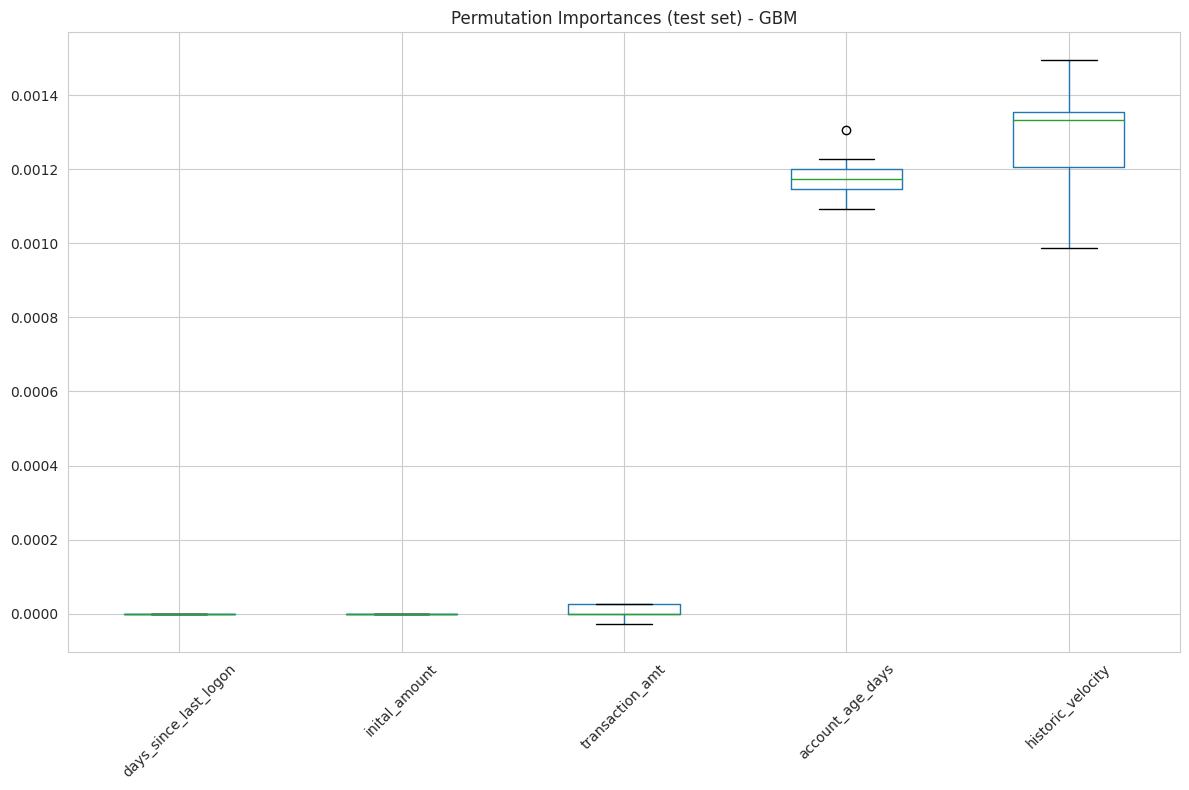

In [ ]:
# Create a function for variable importance
def plot_permutation_importance(model_set, X, y):
    # Split the dataset into training and testing sets
    X_test = X
    y_test = y
    for name, model in model_set.items():

        # Perform permutation importance
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

        # Organize as a DataFrame for easier plotting
        perm_sorted_idx = result.importances_mean.argsort()
        perm_importance_df = pd.DataFrame(result.importances[perm_sorted_idx].T,
                                          columns=X.columns[perm_sorted_idx])

        # Plotting
        plt.figure(figsize=(12, 8))
        perm_importance_df.boxplot()
        plt.title(f'Permutation Importances (test set) - {name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Test the function
plot_permutation_importance(model_set, test[numeric_features], test['EVENT_LABEL'])

### Logistic Model
- evaluate_model(log_pipeline, test, numeric_features)

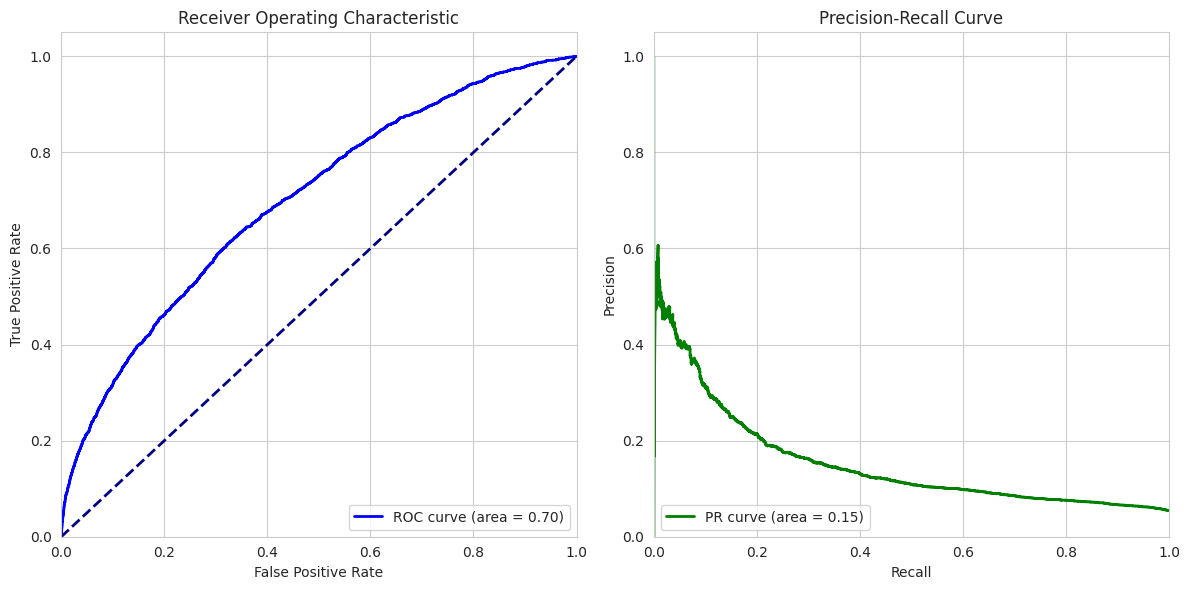

ROC AUC: 0.70
PR AUC: 0.15
F1 Score: 0.00


In [ ]:
def evaluate_model(pipeline, test, numeric_features):
    # Predict probabilities
    probs = pipeline.predict_proba(test[numeric_features])
    preds = probs[:,1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(test['EVENT_LABEL'], preds)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(test['EVENT_LABEL'], preds)
    pr_auc = average_precision_score(test['EVENT_LABEL'], preds)

    # Compute F1 score
    y_pred = pipeline.predict(test[numeric_features])
    f1 = f1_score(test['EVENT_LABEL'], y_pred)

    # Plotting ROC and Precision-Recall curves side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # ROC Curve
    ax[0].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].legend(loc="lower right")

    # Precision-Recall Curve
    ax[1].plot(recall, precision, color='green', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend(loc="lower left")

    plt.tight_layout()
    plt.show()

    # Print results
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"PR AUC: {pr_auc:.2f}")
    print(f"F1 Score: {f1:.2f}")

# Logistic Regression Example:
evaluate_model(log_pipeline, test, numeric_features)

### Random Forest
- evaluate_model(log_pipeline, test, numeric_features)

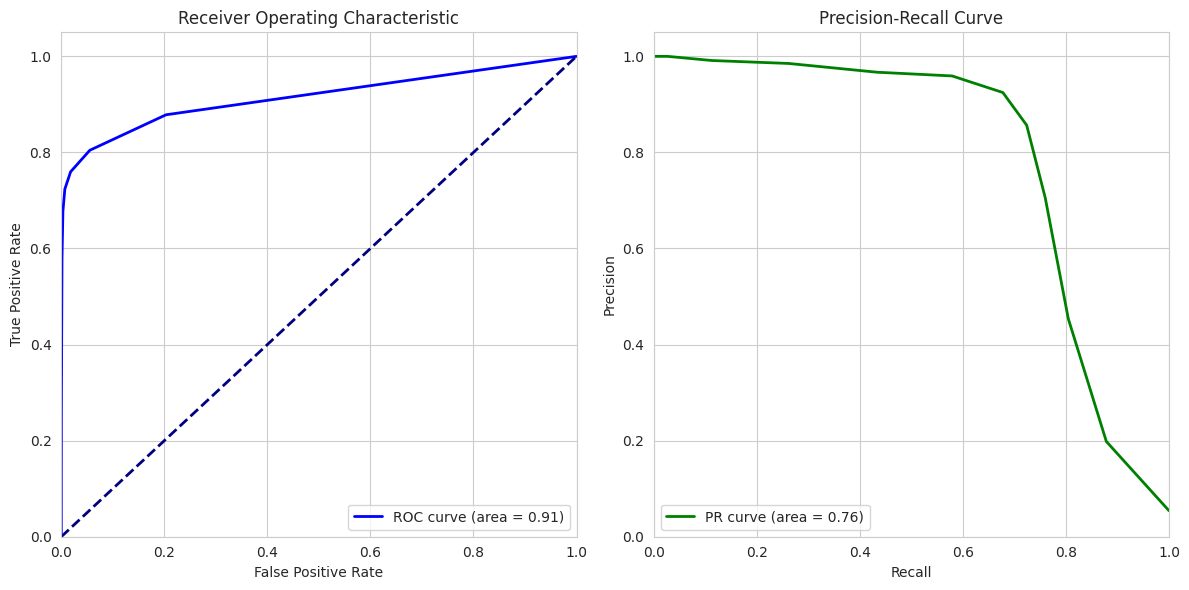

ROC AUC: 0.91
PR AUC: 0.76
F1 Score: 0.72


In [ ]:
# Random Forest Example:
evaluate_model(rf_pipeline, test, numeric_features)

### Gradient Boosting Machine
- evaluate_model(log_pipeline, test, numeric_features)

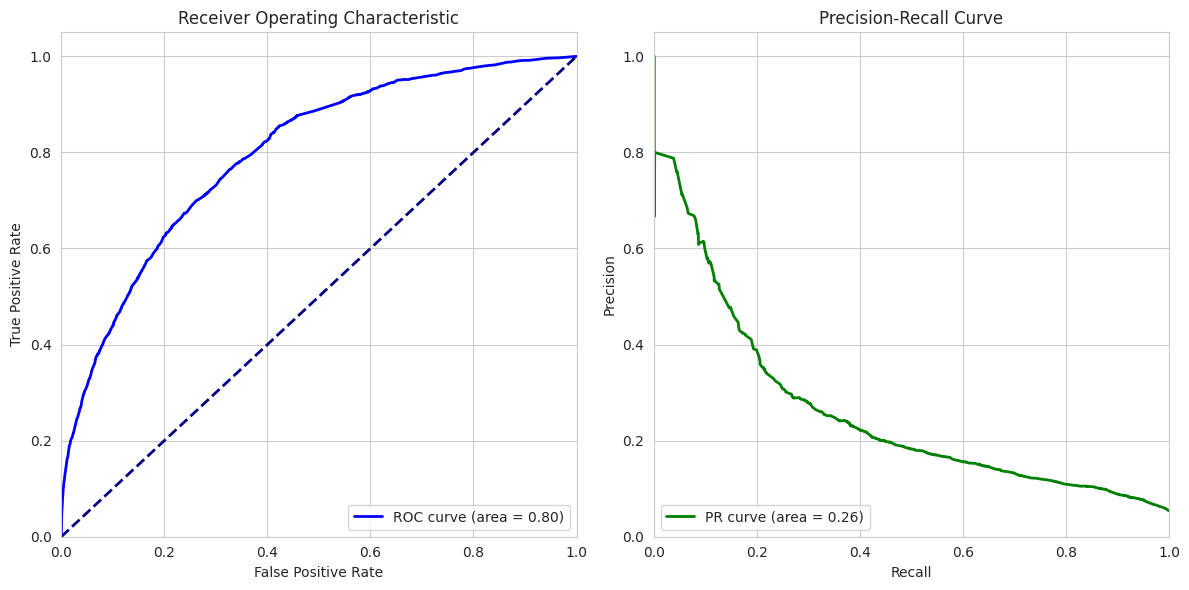

ROC AUC: 0.80
PR AUC: 0.26
F1 Score: 0.00


In [ ]:
# Logistic Regression Example:
evaluate_model(gbm_pipeline, test, numeric_features)

### Get Predictions
- def get_predictions(pipeline, test, numeric_features):

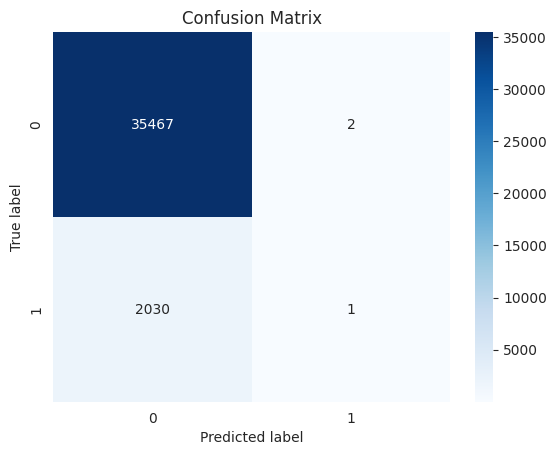

Accuracy: 0.95
Precision: 0.33
Recall: 0.00
True Positive Rate (TPR): 0.049%
False Positive Rate (FPR): 0.006%
Precision: 33.333%


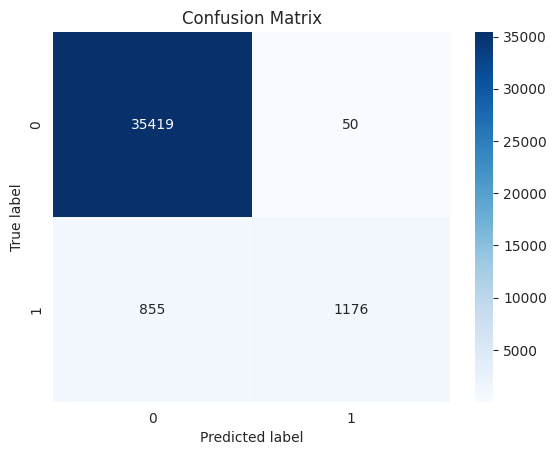

Accuracy: 0.98
Precision: 0.96
Recall: 0.58
True Positive Rate (TPR): 57.903%
False Positive Rate (FPR): 0.141%
Precision: 95.922%


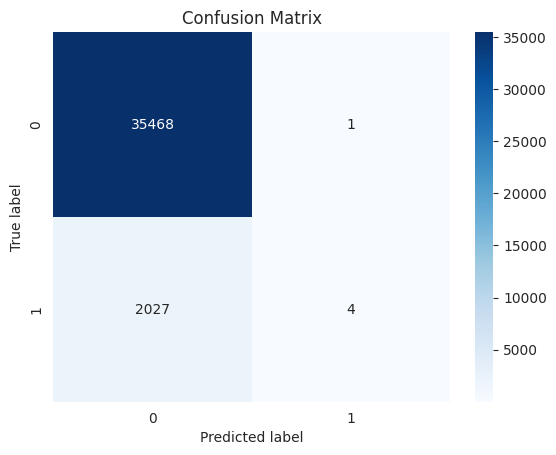

Accuracy: 0.95
Precision: 0.80
Recall: 0.00
True Positive Rate (TPR): 0.197%
False Positive Rate (FPR): 0.003%
Precision: 80.000%


In [ ]:
# Get predictions
def get_predictions(pipeline, test, numeric_features):
  y_pred = pipeline.predict(test[numeric_features])

  # Compute confusion matrix
  cm = confusion_matrix(test['EVENT_LABEL'], y_pred)

  # Plot confusion matrix with seaborn
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.title("Confusion Matrix")
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(test['EVENT_LABEL'], y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Calculate precision
  precision = precision_score(test['EVENT_LABEL'], y_pred)
  print(f'Precision: {precision:.2f}')

  # Calculate recall
  recall = recall_score(test['EVENT_LABEL'], y_pred)
  print(f'Recall: {recall:.2f}')

  # Extracting TN, FP, FN, TP
  TN, FP, FN, TP = cm.ravel()

  # Calculating TPR, FPR, and Precision
  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)
  Precision = TP / (TP + FP)

  # Printing the metrics
  print(f"True Positive Rate (TPR): {TPR:.3%}")
  print(f"False Positive Rate (FPR): {FPR:.3%}")
  print(f"Precision: {Precision:.3%}")

# Logistic Regression
get_predictions(log_pipeline, test, numeric_features)

# Random Forest
get_predictions(rf_pipeline, test, numeric_features)

# Gradient Boosting Machine
get_predictions(gbm_pipeline, test, numeric_features)

In [ ]:
# Get predictions
def get_prediction_metrics(pipeline, test, numeric_features):
  y_pred = pipeline.predict(test[numeric_features])

  # Compute confusion matrix
  cm = confusion_matrix(test['EVENT_LABEL'], y_pred)

  # Calculate accuracy
  accuracy = accuracy_score(test['EVENT_LABEL'], y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Calculate precision
  precision = precision_score(test['EVENT_LABEL'], y_pred)
  print(f'Precision: {precision:.2f}')

  # Calculate recall
  recall = recall_score(test['EVENT_LABEL'], y_pred)
  print(f'Recall: {recall:.2f}')

  # Extracting TN, FP, FN, TP
  TN, FP, FN, TP = cm.ravel()

  # Calculating TPR, FPR, and Precision
  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)
  Precision = TP / (TP + FP)

  # Printing the metrics
  print(f"True Positive Rate (TPR): {TPR:.3%}")
  print(f"False Positive Rate (FPR): {FPR:.3%}")
  print(f"Precision: {Precision:.3%}")

---
# Attempt Two of CookBook Recipe
- We will use both numerical and categorical features

---
## Preprocessing, Fitting Both & Metrics

In [ ]:
feature_names = numeric_features + categorical_features
feature_names

['account_age_days',
 'transaction_amt',
 'historic_velocity',
 'days_since_last_logon',
 'inital_amount',
 'billing_state',
 'currency',
 'cvv',
 'signature_image',
 'transaction_type',
 'transaction_env',
 'locale',
 'tranaction_initiate']

Do another test train and split, and reconfigure the pipelines

In [ ]:
# Create another train and test split
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))

# Edit the processing pipeline
preprocessing = ColumnTransformer(transformers=[
   ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)])

log_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',LogisticRegression(random_state=0, max_iter=150))
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',RandomForestClassifier(n_estimators=10))
])

gbm_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',GradientBoostingClassifier(n_estimators=20))
])


log_pipeline.fit(train[numeric_features + categorical_features], train['EVENT_LABEL'])
rf_pipeline.fit(train[numeric_features + categorical_features], train['EVENT_LABEL'])
gbm_pipeline.fit(train[numeric_features + categorical_features], train['EVENT_LABEL'])

print("2nd Training Complete")

train pct: 70.00%
test  pct: 30.00%
2nd Training Complete


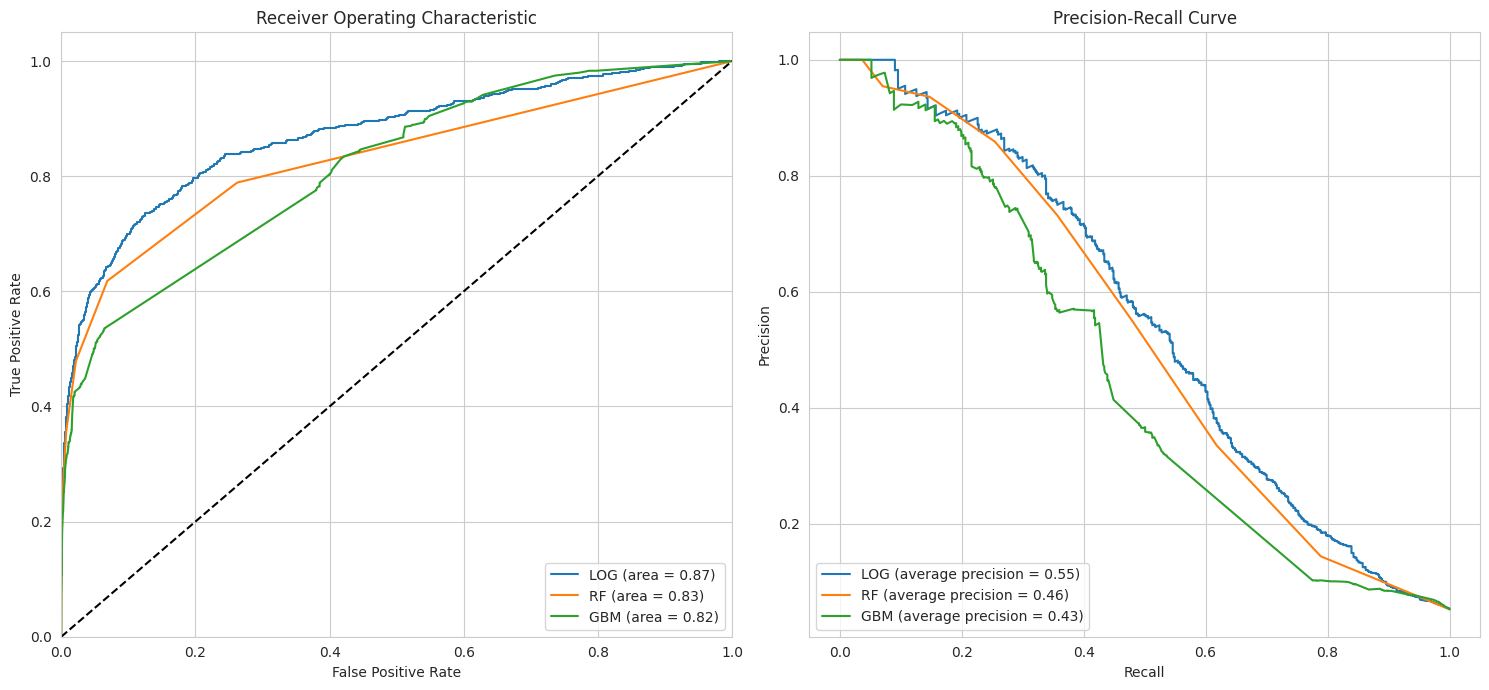

In [ ]:
# Example usage:
model_set = {
    "LOG": log_pipeline, # Logistic Regression Pipeline
    "RF": rf_pipeline,  # Random Forest pipeline
     "GBM": gbm_pipeline  # Gradient Boosting pipeline
 }
plot_model_curves(model_set, test[numeric_features + categorical_features], test['EVENT_LABEL'])

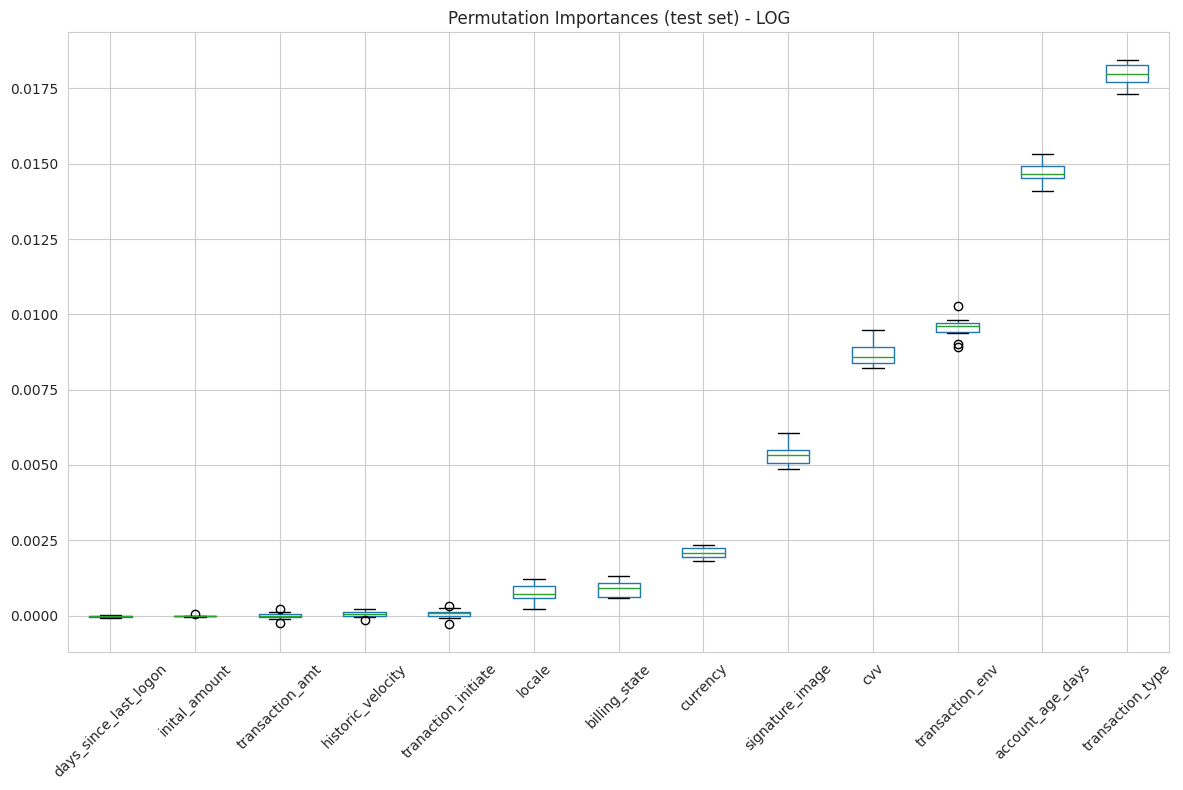

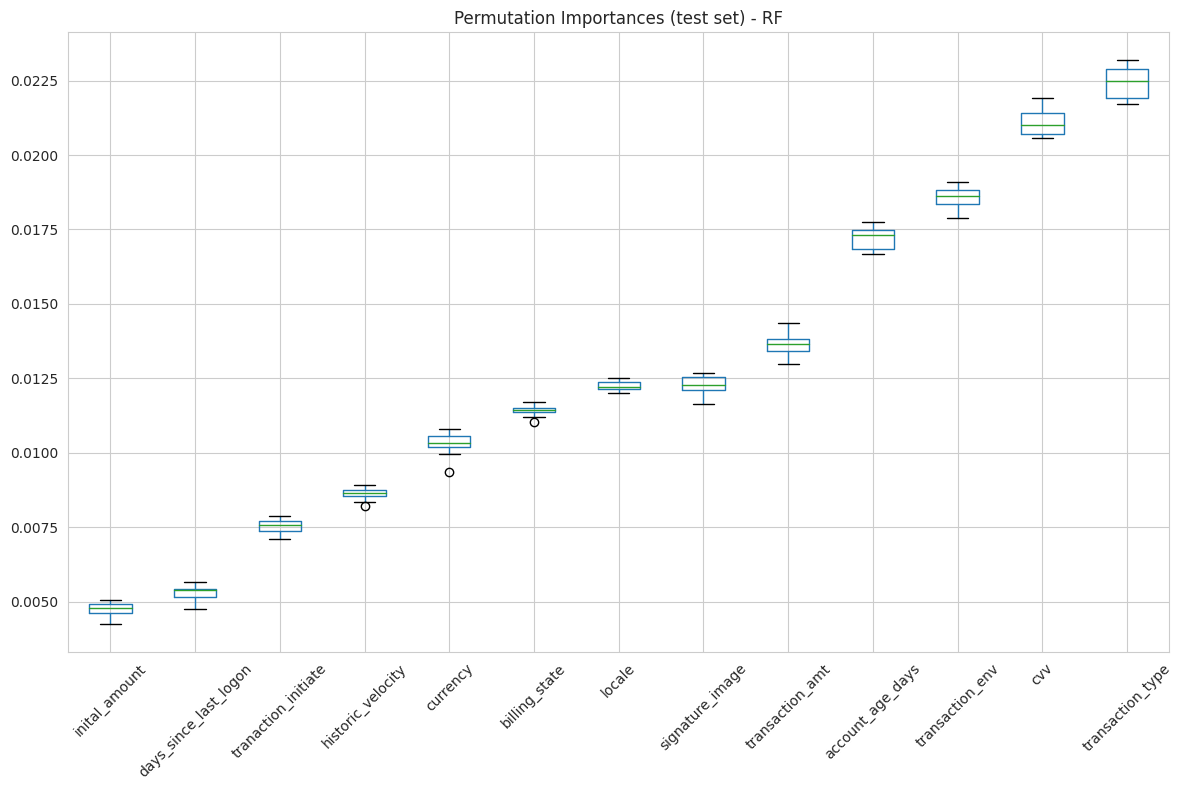

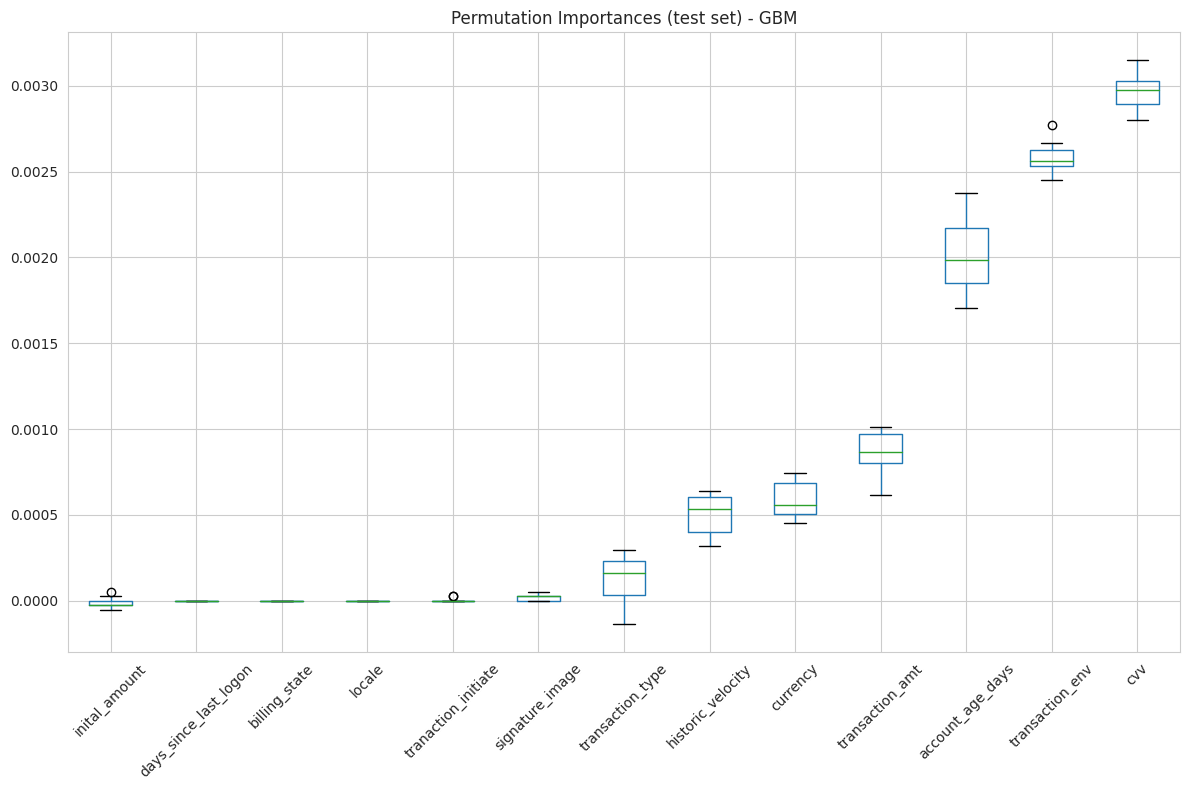

In [ ]:
# Test the function
plot_permutation_importance(model_set, test[feature_names], test['EVENT_LABEL'])

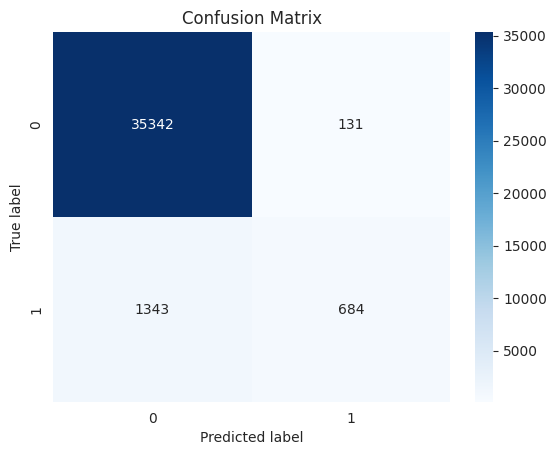

Accuracy: 0.96
Precision: 0.84
Recall: 0.34
True Positive Rate (TPR): 33.744%
False Positive Rate (FPR): 0.369%
Precision: 83.926%


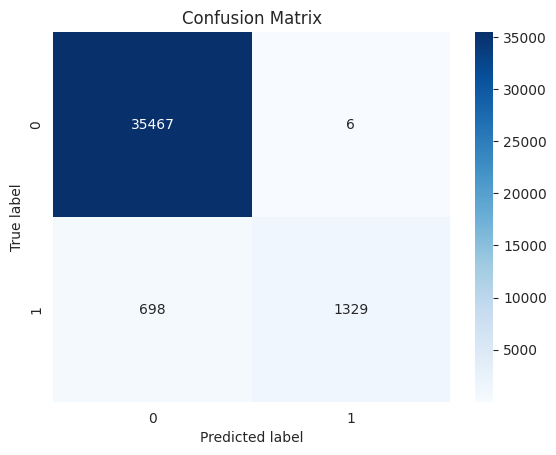

Accuracy: 0.98
Precision: 1.00
Recall: 0.66
True Positive Rate (TPR): 65.565%
False Positive Rate (FPR): 0.017%
Precision: 99.551%


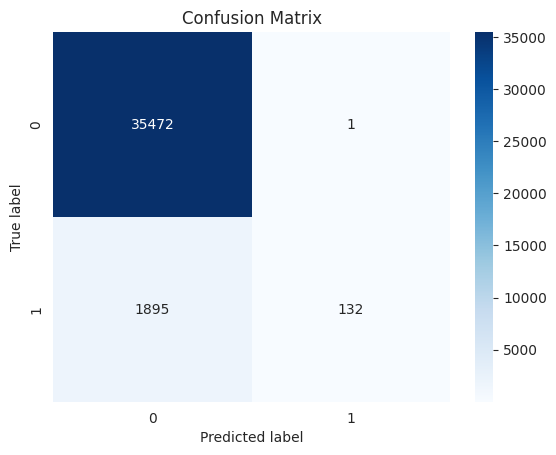

Accuracy: 0.95
Precision: 0.99
Recall: 0.07
True Positive Rate (TPR): 6.512%
False Positive Rate (FPR): 0.003%
Precision: 99.248%


In [ ]:
# Get predictions
def get_predictions(pipeline, test, feature_names):
  y_pred = pipeline.predict(test[feature_names])

  # Compute confusion matrix
  cm = confusion_matrix(test['EVENT_LABEL'], y_pred)

  # Plot confusion matrix with seaborn
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.title("Confusion Matrix")
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(test['EVENT_LABEL'], y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Calculate precision
  precision = precision_score(test['EVENT_LABEL'], y_pred)
  print(f'Precision: {precision:.2f}')

  # Calculate recall
  recall = recall_score(test['EVENT_LABEL'], y_pred)
  print(f'Recall: {recall:.2f}')

  # Extracting TN, FP, FN, TP
  TN, FP, FN, TP = cm.ravel()

  # Calculating TPR, FPR, and Precision
  TPR = TP / (TP + FN)
  FPR = FP / (FP + TN)
  Precision = TP / (TP + FP)

  # Printing the metrics
  print(f"True Positive Rate (TPR): {TPR:.3%}")
  print(f"False Positive Rate (FPR): {FPR:.3%}")
  print(f"Precision: {Precision:.3%}")

# Logistic Regression
get_predictions(log_pipeline, test, feature_names)

# Random Forest
get_predictions(rf_pipeline, test, feature_names)

# Gradient Boosting Machine
get_predictions(gbm_pipeline, test, feature_names)

### Improvements
Differences from including numerical and categorical variables vs numerical

In [273]:
# Logistic Regression
print(f'Logistic Accuracy Difference: +{0.96 - 0.95:.2f}')
print(f'Logistic Precision Difference: +{0.84 - 0.33:.2f}')
print(f'Logistic Recall Difference: +{0.34 - 0.00:.2f}')
print(f'Logistic TPR Difference: +{33.744 - 0.049:.2f}%')
print(f'Logistic FPR Difference: +{0.369 - 0.006:.2f}%')
print(f'Logistic Precision Difference: +{83.926 - 33.333:.2f}%')
#---------------------------------------------------------------
# Random Forest
print(f'\nRandom Forest Accuracy Difference: {0.98 - 0.98:.2f}')
print(f'Random Forest Precision Difference: +{1.00 - 0.96:.2f}')
print(f'Random Forest Recall Difference: +{0.66 - 0.58:.2f}')
print(f'Random Forest TPR Difference: +{65.565 - 57.903:.2f}%')
print(f'Random Forest FPR Difference: {0.017 - 0.141:.2f}%')
print(f'Random Forest Precision Difference: {95.551 - 95.922:.2f}%')
#---------------------------------------------------------------
# Gradient Boosting Machine
print(f'\nGradient Boosting Machine Accuracy Difference: {0.95 - 0.95:.2f}')
print(f'Gradient Boosting Machine Precision Difference: +{0.99 - 0.80:.2f}')
print(f'Gradient Boosting Machine Recall Difference: +{0.07 - 0.00:.2f}')
print(f'Gradient Boosting Machine TPR Difference: +{6.512 - 0.197:.2f}%')
print(f'Gradient Boosting Machine FPR Difference: {0.003 - 0.003:.2f}%')
print(f'Gradient Boosting Machine Precision Difference: +{99.248 - 80.000:.2f}%')

Logistic Accuracy Difference: +0.01
Logistic Precision Difference: +0.51
Logistic Recall Difference: +0.34
Logistic TPR Difference: +33.70%
Logistic FPR Difference: +0.36%
Logistic Precision Difference: +50.59%

Random Forest Accuracy Difference: 0.00
Random Forest Precision Difference: +0.04
Random Forest Recall Difference: +0.08
Random Forest TPR Difference: +7.66%
Random Forest FPR Difference: -0.12%
Random Forest Precision Difference: -0.37%

Gradient Boosting Machine Accuracy Difference: 0.00
Gradient Boosting Machine Precision Difference: +0.19
Gradient Boosting Machine Recall Difference: +0.07
Gradient Boosting Machine TPR Difference: +6.31%
Gradient Boosting Machine FPR Difference: 0.00%
Gradient Boosting Machine Precision Difference: +19.25%


### Feature Importance
1. Logistic
2. Random Forest
3. Gradient Boosting Machine

Random Forest Accuracy: 0.9949

Target FPR: 1.00%, Expected TPR: 0.9990%, Threshold: 0.2342
Target FPR: 2.00%, Expected TPR: 0.9996%, Threshold: 0.1935
Target FPR: 3.00%, Expected TPR: 0.9997%, Threshold: 0.1825
Target FPR: 4.00%, Expected TPR: 0.9997%, Threshold: 0.1715
Target FPR: 5.00%, Expected TPR: 0.9997%, Threshold: 0.1605
Target FPR: 6.00%, Expected TPR: 0.9998%, Threshold: 0.1496
Target FPR: 7.00%, Expected TPR: 0.9998%, Threshold: 0.1386
Target FPR: 8.00%, Expected TPR: 0.9999%, Threshold: 0.1276
Target FPR: 9.00%, Expected TPR: 0.9999%, Threshold: 0.1166
Target FPR: 10.00%, Expected TPR: 1.0000%, Threshold: 0.1056




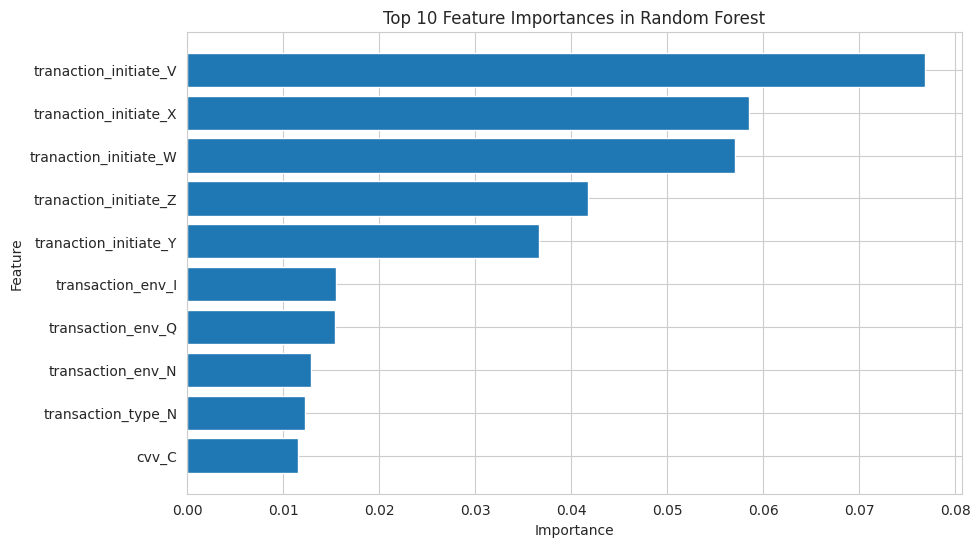

In [ ]:
def random_forest_predictions(pipeline, features, target):
    # Train the Random Forest model
    pipeline.fit(features, target)

    # Predict and evaluate the model
    rf_predictions = pipeline.predict(features)
    rf_predictions_proba = pipeline.predict_proba(features)[:, 1]
    print(f"Random Forest Accuracy: {accuracy_score(target, rf_predictions):.4f}\n")

    # Predict probabilities for the positive class
    y_scores = pipeline.predict_proba(features)[:, 1]
    fpr, tpr, thresholds = roc_curve(target, y_scores)

    # Define target FPR values
    target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

    # Interpolate to find TPR and threshold for target FPRs
    interp_tpr = np.interp(target_fpr, fpr, tpr)
    interp_thresholds = np.interp(target_fpr, fpr, thresholds)

    # Print the results
    for i in range(len(target_fpr)):
        print(f"Target FPR: {target_fpr[i]*100:.2f}%, Expected TPR: {interp_tpr[i]:.4f}%, Threshold: {interp_thresholds[i]:.4f}")

    # Adjusting the feature name extraction
    feature_names = []
    # Extracting feature names for numeric features
    numeric_cols = pipeline.named_steps['preprocess'].transformers_[1][2]
    feature_names.extend(numeric_cols)
    # Extracting feature names for categorical features
    categorical_cols = pipeline.named_steps['preprocess'].transformers_[0][2]
    one_hot_encoder = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)
    feature_names.extend(categorical_feature_names)

    rf_importances = pipeline.named_steps['classifier'].feature_importances_

    # Display the top 10 features
    rf_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
    rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot for Random Forest
    print("\n")
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances in Random Forest')
    plt.barh(rf_feature_importance_df['Feature'][:10], rf_feature_importance_df['Importance'][:10])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.show()

# Random Forest
random_forest_predictions(rf_pipeline, X_train, y_train)

Gradient Boosting Machine Accuracy: 0.9503

Target FPR: 1.00%, Expected TPR: 0.3378%, Threshold: 0.1484
Target FPR: 2.00%, Expected TPR: 0.4198%, Threshold: 0.1066
Target FPR: 3.00%, Expected TPR: 0.4876%, Threshold: 0.0897
Target FPR: 4.00%, Expected TPR: 0.5174%, Threshold: 0.0754
Target FPR: 5.00%, Expected TPR: 0.5357%, Threshold: 0.0700
Target FPR: 6.00%, Expected TPR: 0.5562%, Threshold: 0.0602
Target FPR: 7.00%, Expected TPR: 0.5656%, Threshold: 0.0579
Target FPR: 8.00%, Expected TPR: 0.5734%, Threshold: 0.0579
Target FPR: 9.00%, Expected TPR: 0.5812%, Threshold: 0.0579
Target FPR: 10.00%, Expected TPR: 0.5890%, Threshold: 0.0579




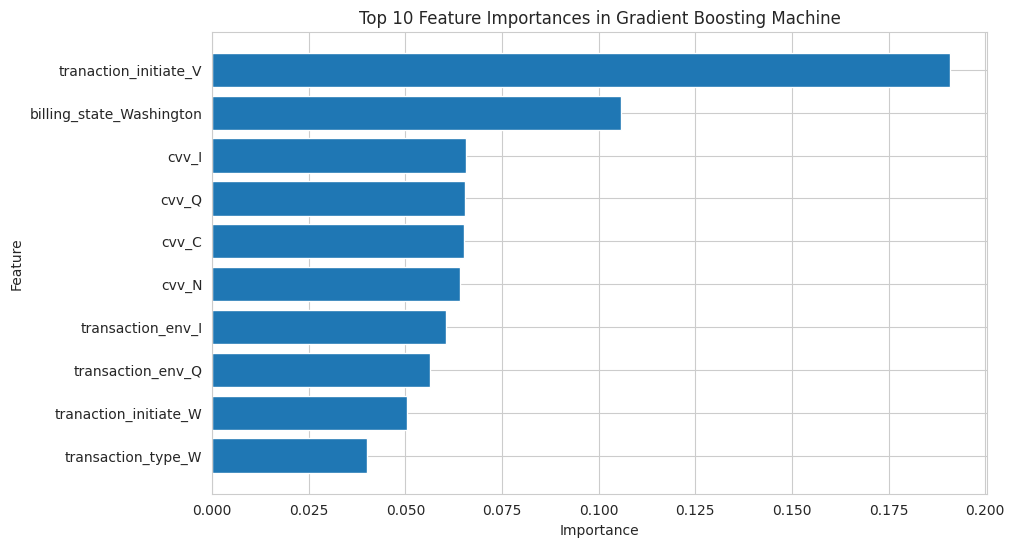

In [ ]:
def gbm_predictions(pipeline, features, target):
    # Train the Gradient Boosting Machine model
    pipeline.fit(features, target)

    # Predict and evaluate the model
    gbm_predictions = pipeline.predict(features)
    gbm_predictions_proba = pipeline.predict_proba(features)[:, 1]
    print(f"Gradient Boosting Machine Accuracy: {accuracy_score(target, gbm_predictions):.4f}\n")

    # Predict probabilities for the positive class
    y_scores = pipeline.predict_proba(features)[:, 1]
    fpr, tpr, thresholds = roc_curve(target, y_scores)

    # Define target FPR values
    target_fpr = np.arange(0.01, 0.11, 0.01)  # From 1% to 10%

    # Interpolate to find TPR and threshold for target FPRs
    interp_tpr = np.interp(target_fpr, fpr, tpr)
    interp_thresholds = np.interp(target_fpr, fpr, thresholds)

    # Print the results
    for i in range(len(target_fpr)):
        print(f"Target FPR: {target_fpr[i]*100:.2f}%, Expected TPR: {interp_tpr[i]:.4f}%, Threshold: {interp_thresholds[i]:.4f}")

    # Extract feature importances
    feature_importances = pipeline.named_steps['classifier'].feature_importances_

    # Get feature names
    feature_names = []
    # Extracting feature names for numeric features
    numeric_cols = pipeline.named_steps['preprocess'].transformers_[1][2]
    feature_names.extend(numeric_cols)
    # Extracting feature names for categorical features
    categorical_cols = pipeline.named_steps['preprocess'].transformers_[0][2]
    one_hot_encoder = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = one_hot_encoder.get_feature_names_out(input_features=categorical_cols)
    feature_names.extend(categorical_feature_names)

    # Create DataFrame with feature names and importances
    gbm_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    gbm_feature_importance_df = gbm_feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot for Gradient Boosting Machine
    print("\n")
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances in Gradient Boosting Machine')
    plt.barh(gbm_feature_importance_df['Feature'][:10], gbm_feature_importance_df['Importance'][:10])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.show()

# Gradient Boosting Machine
gbm_predictions(gbm_pipeline, X_train, y_train)


---
# Attempt Three of Cookbook Recipe with SMOTE
- Here, I will do a X and Y Training and Test Split instead of a regular train and test split, which the original split method included all the feature names and the target

In [215]:
# Let's create a new train and test split
# Identify categorical and numerical columns
target = 'EVENT_LABEL'
feature_names = numeric_features + categorical_features

# Define the target variable
y = df[target].values
X = df[feature_names]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)
print("3rd Training Complete")

3rd Training Complete


---
## SMOTE
SMOTE (Synthetic Minority Oversampling Technique) is a powerful technique used to address class imbalance in machine learning. Let’s dive into what it is and why it’s essential:

1. What is SMOTE?
- SMOTE stands for Synthetic Minority Oversampling Technique.
- It is specifically designed to tackle the challenge of imbalanced classification problems.
- In such scenarios, the target class (e.g., fraudulent transactions, rare diseases, or other minority events) constitutes only a small portion of the dataset.
- The problem arises because traditional models tend to over-predict the majority class due to an unclear “decision boundary.”
2. How Does SMOTE Work?
- SMOTE generates synthetic samples for the minority class.
- Unlike simple oversampling (which duplicates existing data), SMOTE creates new instances by interpolating between positive instances in the feature space.
- It focuses on the feature distribution of the minority class, ensuring that the synthetic examples are plausible and close to the existing data.
3. Purpose of SMOTE:
- Overcoming Imbalance: The primary purpose of SMOTE is to balance the class distribution by increasing the representation of the minority class.
- Avoiding Overfitting: Random oversampling can lead to overfitting, but SMOTE mitigates this issue by creating diverse synthetic samples.
- Enhancing Model Performance: By providing more balanced data, SMOTE helps models better learn the minority class patterns.
Better Decision Boundaries: The synthetic examples help define clearer decision boundaries, improving model accuracy.

In practice, SMOTE is often used in conjunction with under-sampling techniques to achieve a balanced dataset. Under-sampling reduces the majority class, while SMOTE oversamples the minority class, resulting in a more robust training set for machine learning models.

In [216]:
def plot_class_distribution(y, title='Class distribution'):
    counter = Counter(y)
    plt.figure(figsize=(10, 3))
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.ylabel('Frequency')
    plt.xlabel('Class')
    plt.xticks(list(counter.keys()))
    plt.show()

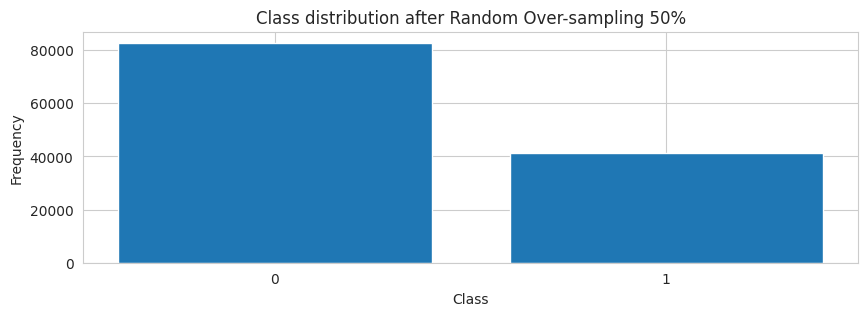

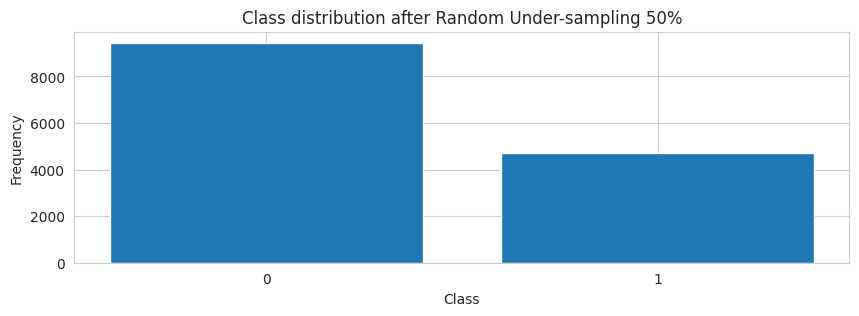

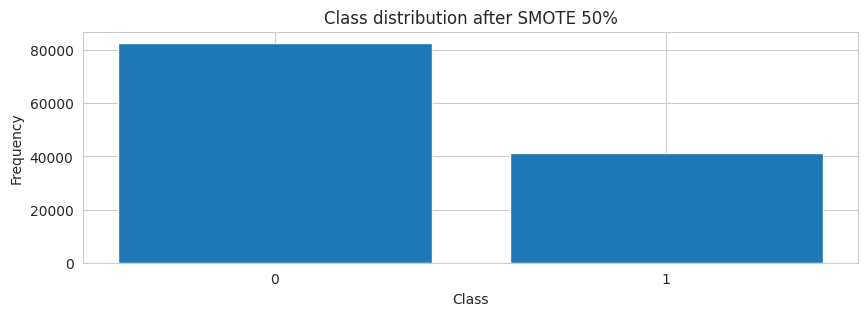

In [217]:
#1. fit your preprocessor & apply it to both Train and Test
X_train_prep = preprocessing.fit_transform(X_train)
X_test_prep  = preprocessing.transform(X_test)

# -- oversampling --
ros = RandomOverSampler(random_state=42, sampling_strategy=0.5)
X_ros, y_ros = ros.fit_resample(X_train_prep, y_train)
plot_class_distribution(y_ros, 'Class distribution after Random Over-sampling 50%')

# -- undersampling --
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
X_rus, y_rus = rus.fit_resample(X_train_prep, y_train)
plot_class_distribution(y_rus, 'Class distribution after Random Under-sampling 50%')

# -- smote --
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_smote, y_smote = smote.fit_resample(X_train_prep, y_train)
plot_class_distribution(y_smote, 'Class distribution after SMOTE 50%')

In [218]:
print('SMOTE Class Distribution')
print(pd.Series(y_smote).value_counts(normalize=True).round(2))
print("SMOTE Class Distribution Count")
print(pd.Series(y_smote).value_counts())

SMOTE Class Distribution
0   0.67000
1   0.33000
dtype: float64
SMOTE Class Distribution Count
0    82775
1    41387
dtype: int64


In [219]:
# -- Logistic Regression SMOTE --

# Define the Logistic Regression Model
lr_pipeline = LogisticRegression(random_state=42, max_iter=150)

# Train the Logistic Regression model
lr_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
lr_predictions = lr_pipeline.predict(X_test_prep)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
#-----------------------------------------------------------------------------------------------
# -- Random Forest Classifier SMOTE

# Define the Random Forest Classifier Model
rfc_pipeline = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

# Train the RandomForestClassifier model
rfc_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
rf_predictions = rfc_pipeline.predict(X_test_prep)
print(f"RandomForestClassifier Accuracy: {accuracy_score(y_test, rf_predictions):.4f}")
#-----------------------------------------------------------------------------------------------
# -- Gradient Boosting Machine SMOTE

# Define the Gradient Boosting Machine Model
gbmm_pipeline = GradientBoostingClassifier(n_estimators=20, random_state=42)

# Train the GBMClassifier model
gbmm_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
gbm_predictions = gbmm_pipeline.predict(X_test_prep)
print(f"GBMClassifier Accuracy: {accuracy_score(y_test, gbm_predictions):.4f}")

Logistic Regression Accuracy: 0.9131
RandomForestClassifier Accuracy: 0.9597
GBMClassifier Accuracy: 0.9506


## Fitting transformed SMOTE data

0.8896065824366083
0.8839683164763638
0.8509323155230226


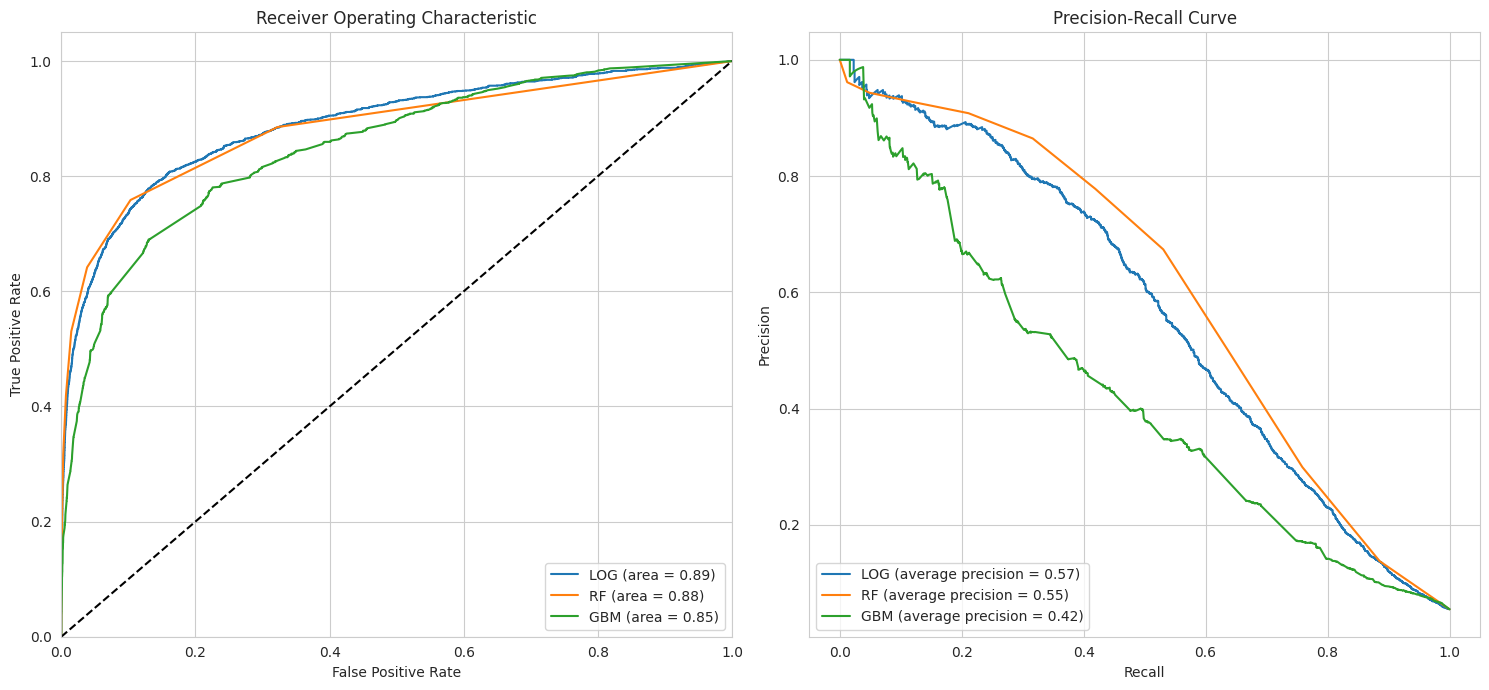

In [230]:
def plot_smote_model_curves(model_set, X, y):
    # Plot Figure
    plt.figure(figsize=(15, 7))

    # ROC Curve plot
    plt.subplot(1, 2, 1)
    for name, model in model_set.items():
        # Fit the model
        model.fit(X, y)
        # Get predicted probabilities
        y_score = model.predict_proba(X_test_prep)[:, 1]
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        print(roc_auc)
        # Plot
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # PR Curve plot
    plt.subplot(1, 2, 2)
    for name, model in model_set.items():
        # Get predicted probabilities
        y_score = model.predict_proba(X_test_prep)[:, 1]
        # Compute PR curve and PR area
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        average_precision = average_precision_score(y_test, y_score)
        # Plot
        plt.plot(recall, precision, label=f'{name} (average precision = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Example usage:
model_set = {
    "LOG": lr_pipeline, # Logistic Regression Pipeline
    "RF": rfc_pipeline,  # Random Forest pipeline
     "GBM": gbmm_pipeline  # Gradient Boosting pipeline
 }
plot_smote_model_curves(model_set, X_smote, y_smote)


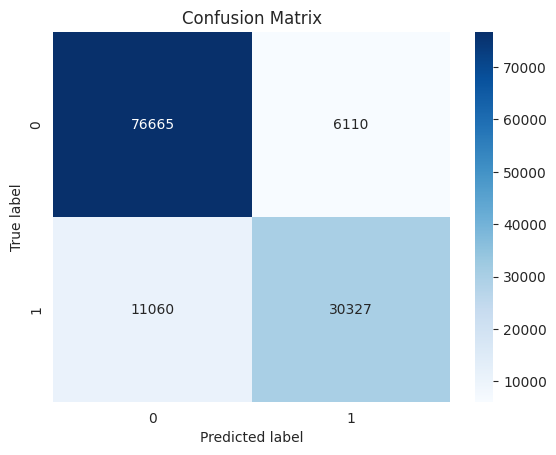

Accuracy: 0.86
Precision: 0.83
Recall: 0.73
True Positive Rate (TPR): 73.277%
False Positive Rate (FPR): 7.381%
Precision: 83.231%


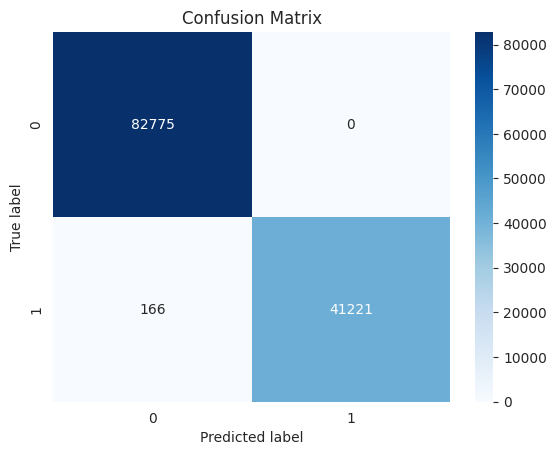

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
True Positive Rate (TPR): 99.599%
False Positive Rate (FPR): 0.000%
Precision: 100.000%


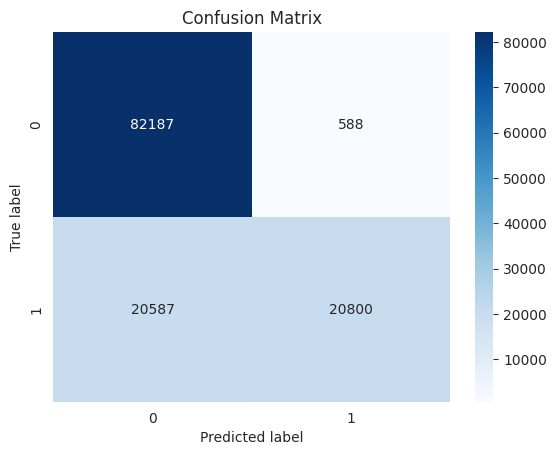

Accuracy: 0.83
Precision: 0.97
Recall: 0.50
True Positive Rate (TPR): 50.257%
False Positive Rate (FPR): 0.710%
Precision: 97.251%


In [237]:
def get_smote_predictions(pipeline, X, y):
    y_pred = pipeline.predict(X)

    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Plot confusion matrix with seaborn
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Calculate precision
    precision = precision_score(y, y_pred)
    print(f'Precision: {precision:.2f}')

    # Calculate recall
    recall = recall_score(y, y_pred)
    print(f'Recall: {recall:.2f}')

    # Extracting TN, FP, FN, TP
    TN, FP, FN, TP = cm.ravel()

    # Calculating TPR, FPR, and Precision
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    Precision = TP / (TP + FP)

    # Printing the metrics
    print(f"True Positive Rate (TPR): {TPR:.3%}")
    print(f"False Positive Rate (FPR): {FPR:.3%}")
    print(f"Precision: {Precision:.3%}")

# Logistic Regression
get_smote_predictions(lr_pipeline, X_smote, y_smote)

# Random Forest
get_smote_predictions(rfc_pipeline, X_smote, y_smote)

# Gradient Boosting Machine
get_smote_predictions(gbmm_pipeline, X_smote, y_smote)


---
# Hyperparameterizing for Accuracy & ROC Curve

---
## Train and Evaluate Classifiers (Logistic Regression, Random Forest, GBM or XG Boost)
- Logistic Regression
> Serves as a baseline for performance compensation
- Random Forest
> An ensemble method known for its robustness and ability to handle complex data structures
- Gradient Boosting Machine (GBM) or XG Boost
> Advanced ensemble technique known for their predictive power
---

## Tuning the models with Hyper-Paramertization (Grid-Search, Random Search, Bayesian)


### Logistic Regression
- Accuracy

In [250]:
preprocessing = ColumnTransformer(transformers=[
   ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)])

log_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',LogisticRegression(random_state=42, max_iter=150))
])

rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',RandomForestClassifier(n_estimators=10))
])

gbm_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier',GradientBoostingClassifier(n_estimators=20))
])

In [252]:
log_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['billing_state', 'currency',
                                                   'cvv', 'signature_image',
                                                   'transaction_type',
                                                   'transaction_env', 'locale',
                                                   'tranaction_initiate']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'inital_amount'])])),
                ('classifier',
                 LogisticRegression(max_iter=150, random_state=42))])

In [251]:
lr_pipeline

LogisticRegression(max_iter=150, random_state=42)

In [ ]:
# Let's create a new train and test split
# -- define pipelines --

# Identify categorical and numerical columns
#target = 'EVENT_LABEL'
#feature_names = numeric_features + categorical_features

# Define the target variable
#y = df[target].values
#X = df[feature_names]

# Splitting the dataset into the Training set and Test set
#X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)
#print("3rd Training Complete")

In [ ]:
# define evaluation
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Create a grid space
param_grid = {
    'C': [0.001, 0.01, .1, .2, 0.5, .75, 1],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300, 400],
    'solver': ['liblinear']
}

gs = GridSearchCV(lr_pipeline, param_grid, scoring='accuracy', cv=3)
gs.fit(X_smote, y_smote)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=150, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1],
                         'max_iter': [100, 200, 300, 400],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [ ]:
# Best Accuracy Score
print(gs.best_params_)

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# -- Logistic Regression SMOTE --

# Define the Logistic Regression Model
smote_lr_pipeline = LogisticRegression(C=1, random_state=42, max_iter=100, penalty='l1', solver='liblinear')

# Train the Logistic Regression model
smote_lr_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_lr_predictions = smote_lr_pipeline.predict(X_test_prep)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, smote_lr_predictions):.4f}")

Logistic Regression Accuracy: 0.9132


#### AUC

In [ ]:
 from sklearn.model_selection import RandomizedSearchCV

# Create a grid space
param_grid = {
    'C': [0.01, .1, .25, 0.5, .75, 1],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300],
    'solver': ['liblinear']
}

gs = RandomizedSearchCV(lr_pipeline, param_grid, scoring='roc_auc', cv=3)
gs.fit(X_smote, y_smote)

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=150, random_state=42),
                   param_distributions={'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   scoring='roc_auc')

In [ ]:
# Best Accuracy Score
print(gs.best_params_)

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 300, 'C': 0.75}


In [ ]:
# -- Logistic Regression SMOTE --

# Define the Logistic Regression Model
smote_lr_pipeline = LogisticRegression(C=0.75, random_state=42, max_iter=300, penalty='l1', solver='liblinear')

# Train the Logistic Regression model
smote_lr_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_lr_predictions = smote_lr_pipeline.predict(X_test_prep)
fpr, tpr, _ = roc_curve(y_test, smote_lr_predictions)
roc_auc = auc(fpr, tpr)
print(f"Logistic ROC Curve: {roc_auc:.2f}")

Logistic ROC Curve: 0.81


### Random Forest

In [ ]:
rfc_pipeline

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [ ]:
# Create a grid space
param_grid = {
 'bootstrap': [True, False],
 'max_depth': [1,2,3, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1,2,3]}

gs = RandomizedSearchCV(rfc_pipeline, param_grid, scoring='accuracy', cv=3)
gs.fit(X_smote, y_smote)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                                    random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 2, 3]},
                   scoring='accuracy')

In [ ]:
# Best Accuracy Score
print(gs.best_params_)

{'n_estimators': 3, 'min_samples_split': 5, 'max_depth': None, 'bootstrap': False}


In [ ]:
# -- Random Forest Classifier SMOTE

# Define the Random Forest Classifier Model
smote_rfc_pipeline = RandomForestClassifier(n_estimators=3, min_samples_split=5, max_depth=None, bootstrap=False, n_jobs=--1, random_state=42)

# Train the RandomForestClassifier model
smote_rfc_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_rf_predictions = smote_rfc_pipeline.predict(X_test_prep)
print(f"RandomForestClassifier Accuracy: {accuracy_score(y_test, smote_rf_predictions):.4f}")

RandomForestClassifier Accuracy: 0.9546


In [253]:
# Visualize the first tree in the RandomForest
#tree_in_forest = smote_rfc_pipeline.estimators_[0]
#plt.figure(figsize=(20, 10))
#plot_tree(tree_in_forest, filled=True)
#plt.title("Decision Tree 1 in RandomForest")
#plt.show()

In [254]:
#from sklearn.tree import plot_tree
# Visualize the first few trees in the RandomForest
#for i, tree_in_forest in enumerate(smote_rfc_pipeline.estimators_[:3]):
    #plt.figure(figsize=(20, 10))
    #plot_tree(tree_in_forest, filled=True)
    #plt.title(f"Decision Tree {i+1} in RandomForest")
    #plt.show()

trees:1, accuracy:0.9336
trees:2, accuracy:0.9519
trees:3, accuracy:0.9546
trees:4, accuracy:0.9573
trees:5, accuracy:0.9594
trees:6, accuracy:0.9601
trees:7, accuracy:0.9605


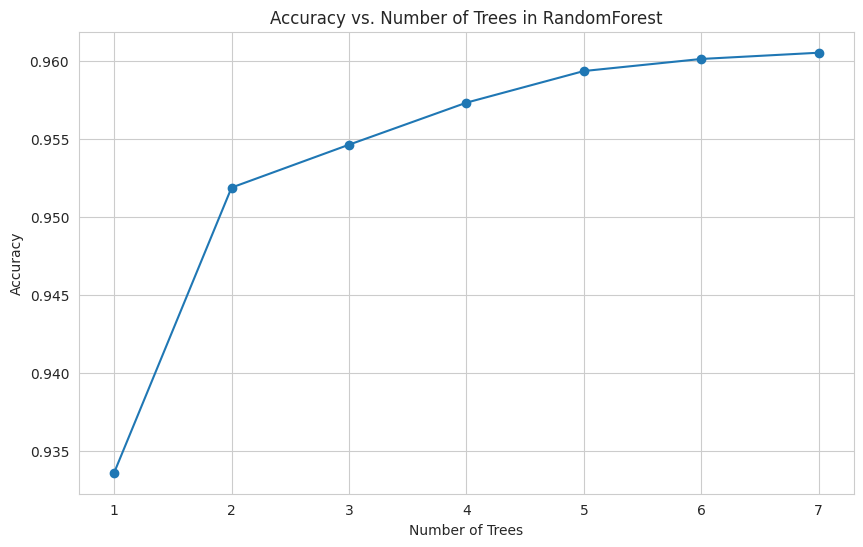

In [ ]:
# List to store accuracies
accuracies = []

# Train RandomForest models with increasing number of trees
n_trees_options = [1, 2, 3, 4, 5, 6, 7]
for n_trees in n_trees_options:
    smote_rfc_pipeline = RandomForestClassifier(n_estimators=n_trees, min_samples_split=5, max_depth=None, bootstrap=False, n_jobs=--1, random_state=42)
    smote_rfc_pipeline.fit(X_smote, y_smote)
    smote_rf_predictions = smote_rfc_pipeline.predict(X_test_prep)
    accuracy = accuracy_score(y_test, smote_rf_predictions)
    accuracies.append(accuracy)
    print(f"trees:{n_trees}, accuracy:{accuracy:.4f}")

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_trees_options, accuracies, marker='o')
plt.title('Accuracy vs. Number of Trees in RandomForest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [255]:
# Create a grid space
param_grid = {
 'bootstrap': [True, False],
 'max_depth': [1,2,3, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1,2,3]}

rs = RandomizedSearchCV(rfc_pipeline, param_grid, scoring='roc_auc', cv=3)
rs.fit(X_smote, y_smote)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1,
                                                    random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 2, 3]},
                   scoring='roc_auc')

In [256]:
# Best Accuracy Score
print(rs.best_params_)

{'n_estimators': 2, 'min_samples_split': 10, 'max_depth': None, 'bootstrap': False}


In [260]:
# -- Random Forest Classifier SMOTE

# Define the Random Forest Classifier Model
smote_rfc_pipeline = RandomForestClassifier(n_estimators=2, min_samples_split=10, max_depth=None, bootstrap=False, n_jobs=--1, random_state=42)

# Train the RandomForestClassifier model
smote_rfc_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_rf_predictions = smote_rfc_pipeline.predict(X_test_prep)
fpr, tpr, _ = roc_curve(y_test, smote_rf_predictions)
roc_auc = auc(fpr, tpr)
print(f"Random Forest ROC Curve: {roc_auc:.2f}")

Random Forest ROC Curve: 0.64


trees:1, ROC AUC:0.7267
trees:2, ROC AUC:0.8010
trees:3, ROC AUC:0.8423
trees:4, ROC AUC:0.8648
trees:5, ROC AUC:0.8786
trees:6, ROC AUC:0.8877
trees:7, ROC AUC:0.8914


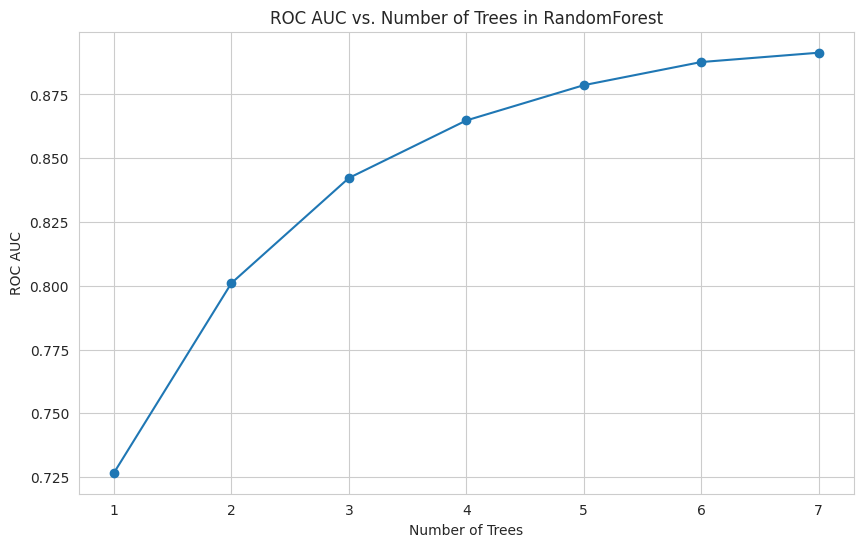

In [261]:
# List to store ROC AUC scores
roc_auc_scores = []

# Train RandomForest models with increasing number of trees
n_trees_options = [1, 2, 3, 4, 5, 6, 7]
for n_trees in n_trees_options:
    smote_rfc_pipeline = RandomForestClassifier(n_estimators=n_trees, min_samples_split=10, max_depth=None, bootstrap=False, n_jobs=-1, random_state=42)
    smote_rfc_pipeline.fit(X_smote, y_smote)
    smote_rf_predictions_proba = smote_rfc_pipeline.predict_proba(X_test_prep)[:, 1]
    roc_auc = roc_auc_score(y_test, smote_rf_predictions_proba)
    roc_auc_scores.append(roc_auc)
    print(f"trees:{n_trees}, ROC AUC:{roc_auc:.4f}")

# Plot the ROC AUC scores
plt.figure(figsize=(10, 6))
plt.plot(n_trees_options, roc_auc_scores, marker='o')
plt.title('ROC AUC vs. Number of Trees in RandomForest')
plt.xlabel('Number of Trees')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

In [262]:
# Define the Random Forest Classifier Model
smote_rfc_pipeline = RandomForestClassifier(n_estimators=7, min_samples_split=10, max_depth=None, bootstrap=False, n_jobs=--1, random_state=42)

# Train the RandomForestClassifier model
smote_rfc_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_rf_predictions = smote_rfc_pipeline.predict(X_test_prep)
fpr, tpr, _ = roc_curve(y_test, smote_rf_predictions)
roc_auc = auc(fpr, tpr)
print(f"Random Forest ROC Curve: {roc_auc:.2f}")

Random Forest ROC Curve: 0.68


### Gradient Boosting Machine

In [ ]:
gbmm_pipeline

GradientBoostingClassifier(n_estimators=20, random_state=42)

In [ ]:
# Create a grid space
param_grid = {
 'learning_rate': [0.01, .05, .1, .2, .3],
 'max_depth': [1, 2, 3, 4, 5, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1, 2, 3, 4]
}

rs = RandomizedSearchCV(gbmm_pipeline, param_grid, scoring='accuracy', cv=3)
rs.fit(X_smote, y_smote)

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(n_estimators=20,
                                                        random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 2, 3, 4]},
                   scoring='accuracy')

In [ ]:
# Best Accuracy Score
print(rs.best_params_)

{'n_estimators': 4, 'min_samples_split': 2, 'max_depth': 4, 'learning_rate': 0.3}


In [ ]:
# -- Gradient Boosting Machine SMOTE

# Define the Gradient Boosting Machine Model
smote_gbmm_pipeline = GradientBoostingClassifier(n_estimators=4, min_samples_split=2, max_depth=4, learning_rate=0.3,  random_state=42)

# Train the GBMClassifier model
smote_gbmm_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_gbm_predictions = smote_gbmm_pipeline.predict(X_test_prep)
print(f"GBMClassifier Accuracy: {accuracy_score(y_test, smote_gbm_predictions):.4f}")

GBMClassifier Accuracy: 0.9489


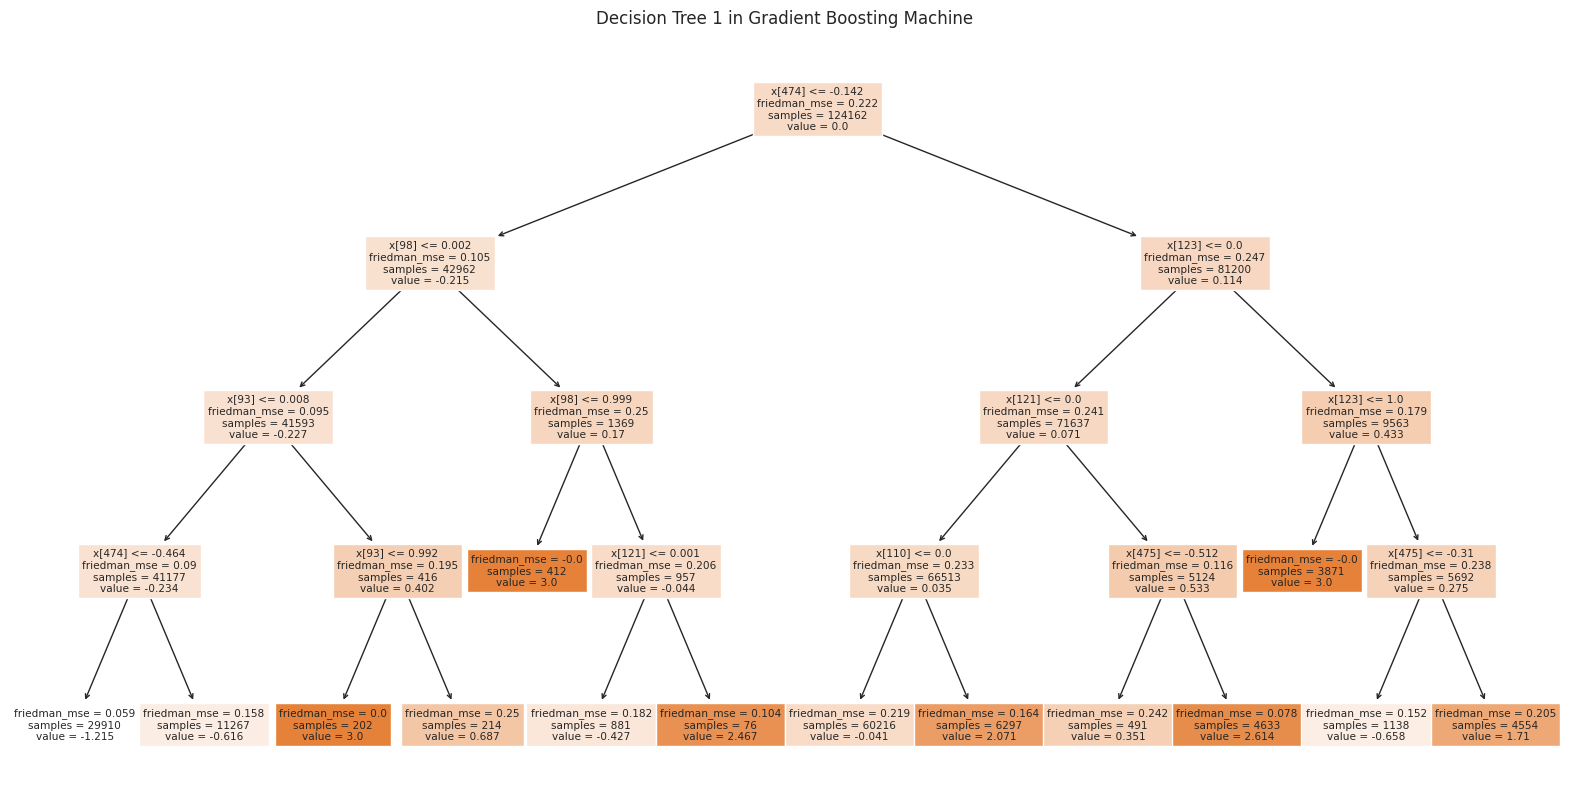

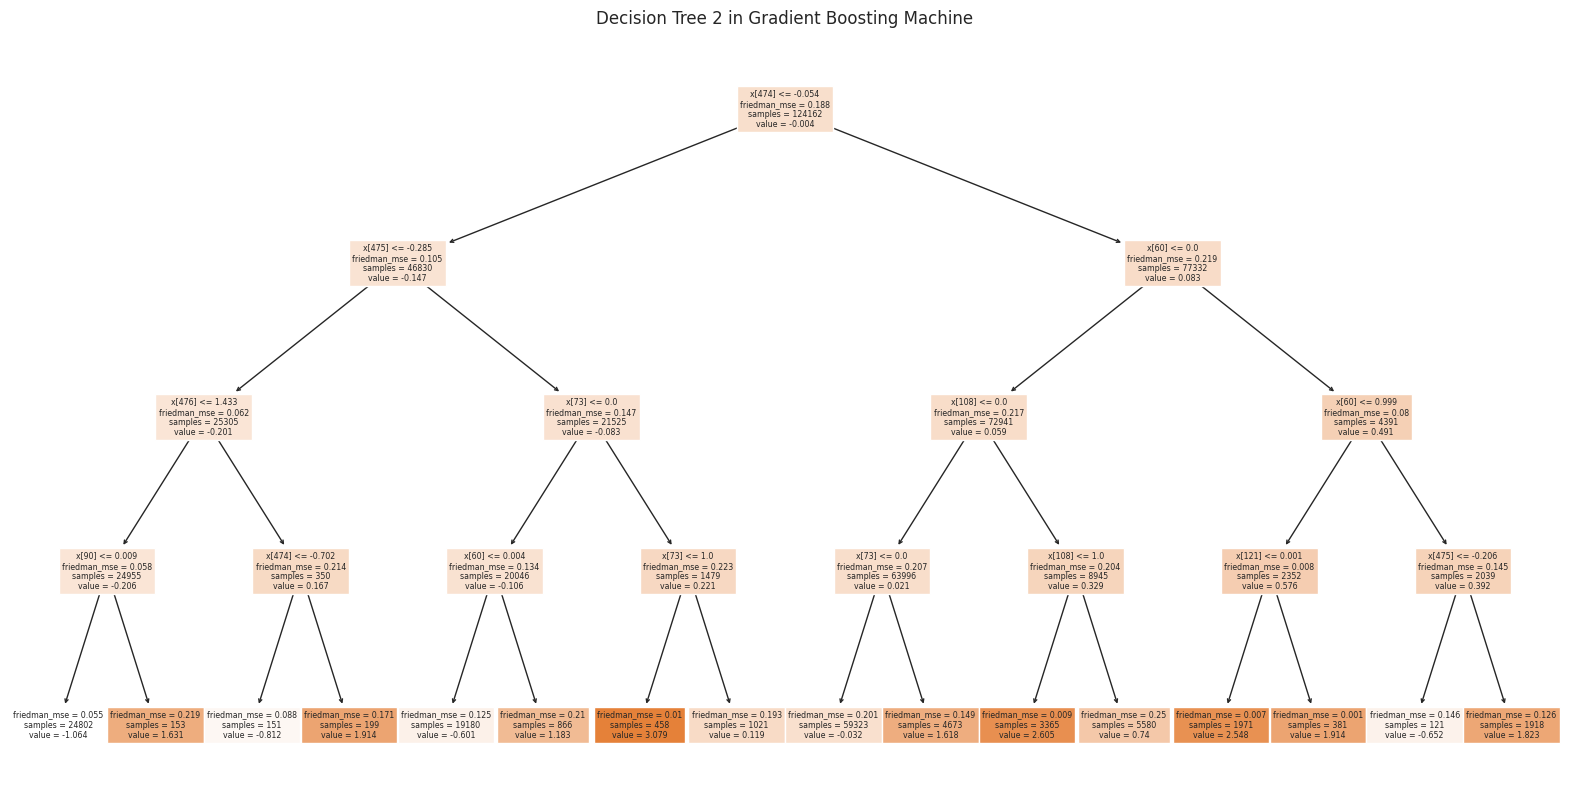

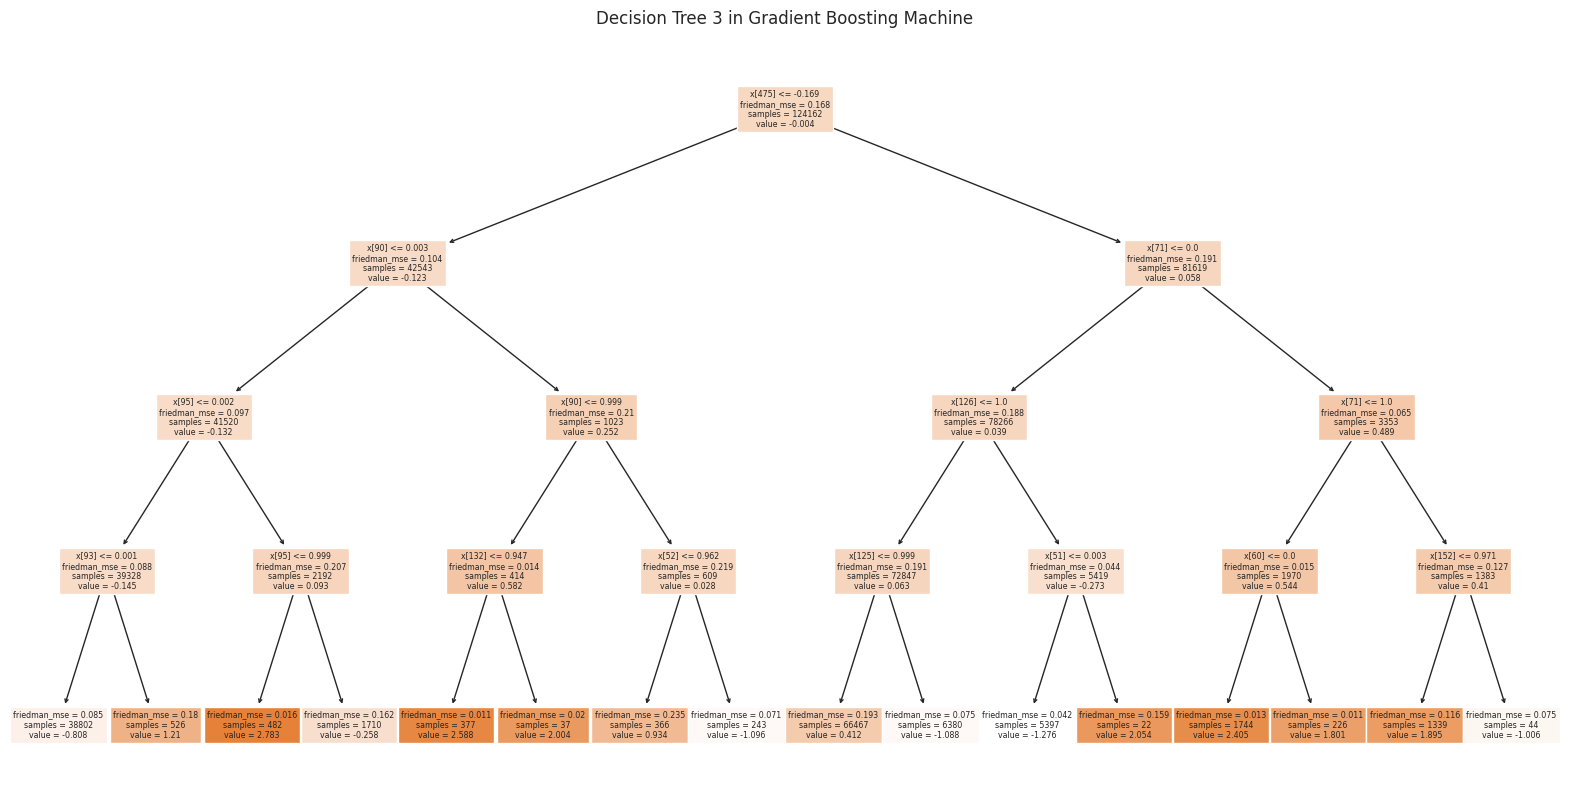

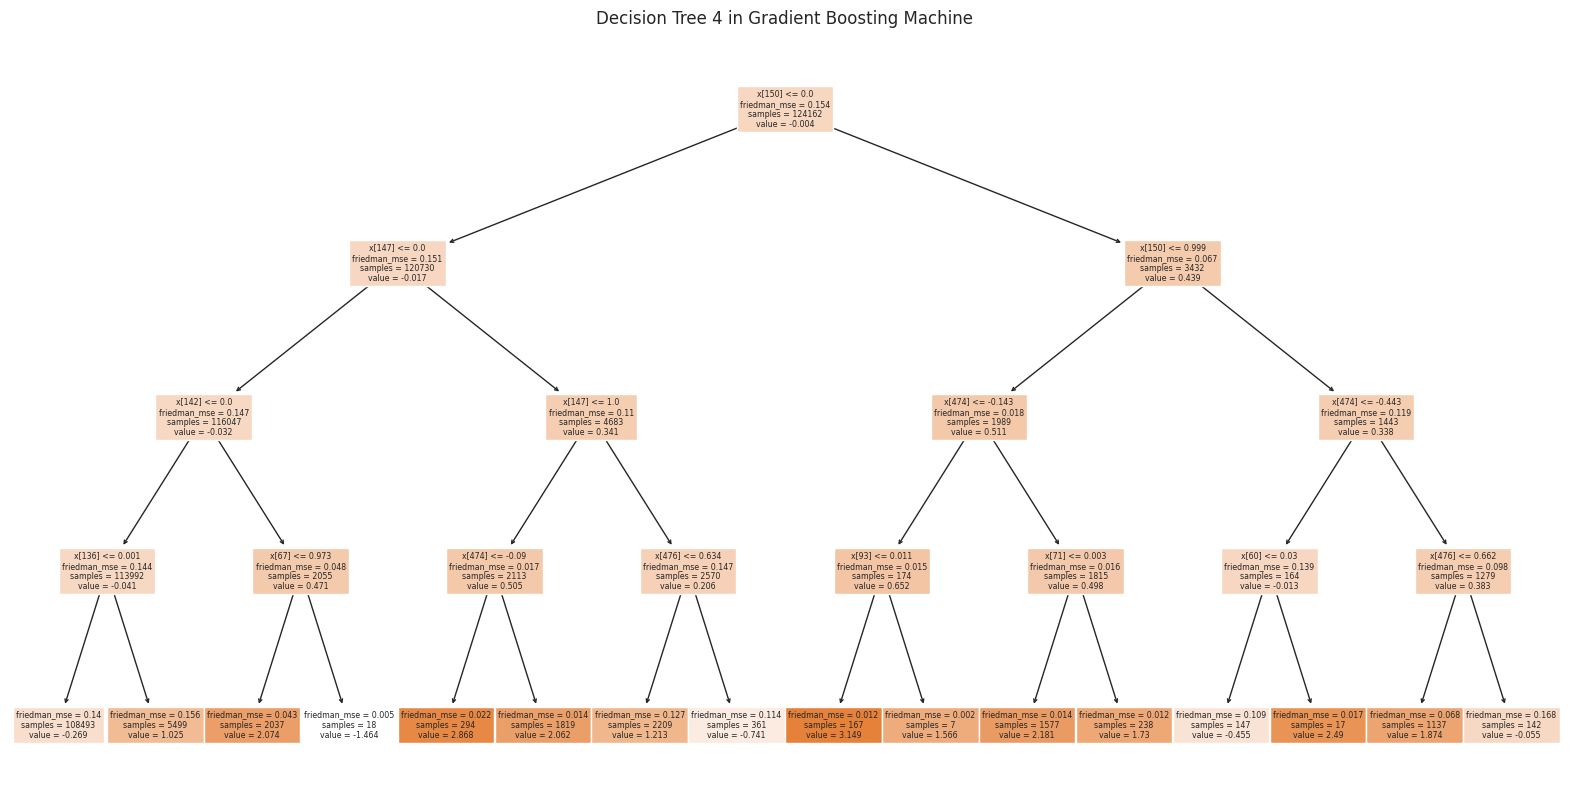

In [ ]:
# Visualize all the trees in the Gradient Boosting Machine
for i in range(smote_gbmm_pipeline.n_estimators_):
    tree_in_gbm = smote_gbmm_pipeline.estimators_[i, 0]
    plt.figure(figsize=(20, 10))
    plot_tree(tree_in_gbm, filled=True)
    plt.title(f"Decision Tree {i+1} in Gradient Boosting Machine")
    plt.show()

In [263]:
# Create a grid space
param_grid = {
 'learning_rate': [0.01, .05, .1, .2, .3],
 'max_depth': [1, 2, 3, 4, 5, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [1, 2, 3, 4]
}

rs = RandomizedSearchCV(gbmm_pipeline, param_grid, scoring='roc_auc', cv=3)
rs.fit(X_smote, y_smote)

RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingClassifier(n_estimators=20,
                                                        random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [1, 2, 3, 4, 5, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1, 2, 3, 4]},
                   scoring='roc_auc')

In [264]:
# Best Accuracy Score
print(rs.best_params_)

{'n_estimators': 4, 'min_samples_split': 10, 'max_depth': None, 'learning_rate': 0.05}


In [274]:
# -- Gradient Boosting Machine SMOTE

# Define the Gradient Boosting Machine Model
smote_gbmm_pipeline = GradientBoostingClassifier(n_estimators=4, min_samples_split=10, max_depth=None, learning_rate=0.05,  random_state=42)

# Train the GBMClassifier model
smote_gbmm_pipeline.fit(X_smote, y_smote)

# Predict and evaluate the model
smote_gbm_predictions = smote_gbmm_pipeline.predict(X_test_prep)
fpr, tpr, _ = roc_curve(y_test, smote_gbm_predictions)
roc_auc = auc(fpr, tpr)
print(f"Gradient Boosting Machine ROC Curve: {roc_auc:.2f}")

Gradient Boosting Machine ROC Curve: 0.50


trees:0.05, ROC AUC:0.7961
trees:0.1, ROC AUC:0.7935
trees:0.2, ROC AUC:0.8153
trees:0.3, ROC AUC:0.8156


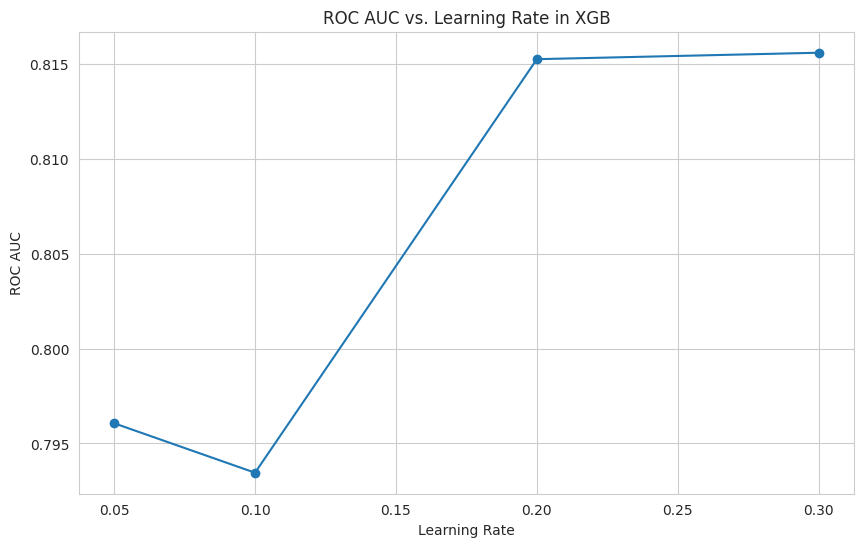

In [272]:
# List to store ROC AUC scores
roc_auc_scores = []

# Train RandomForest models with increasing number of trees
learning_rate_options = [0.05, .1, .2, .3]
for l_rate in learning_rate_options:
    smote_gbmm_pipeline = GradientBoostingClassifier(n_estimators=4, min_samples_split=10, max_depth=None, learning_rate=l_rate, random_state=42)
    smote_gbmm_pipeline.fit(X_smote, y_smote)
    smote_rf_predictions_proba = smote_gbmm_pipeline.predict_proba(X_test_prep)[:, 1]
    roc_auc = roc_auc_score(y_test, smote_rf_predictions_proba)
    roc_auc_scores.append(roc_auc)
    print(f"trees:{l_rate}, ROC AUC:{roc_auc:.4f}")

# Plot the ROC AUC scores
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_options, roc_auc_scores, marker='o')
plt.title('ROC AUC vs. Learning Rate in XGB')
plt.xlabel('Learning Rate')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()

---
# Best model and making predictions on holdout set


In [288]:
# Load the holdout dataset by unzipping the file
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Ames Projects Python and SQL/project_2_holdout.csv.zip') as zip_ref:
  zip_ref.extractall('')

# Load the data set
df_holdout = pd.read_csv('project_2_holdout.csv')

# Display the first few rows of the dataframe
df_holdout.head()

EVENT_ID  account_age_days  transaction_amt  transaction_adj_amt  \
0    109420              4462             3648                   54   
1   1049060              3360             2180                   54   
2   2805320              4725             2063                   60   
3    450840              5336             2319                   72   
4    423160              6115             3413                   61   

   historic_velocity      ip_address  \
0               6325  197.108.209.59   
1               4030  178.166.190.20   
2               4372    163.48.86.34   
3               4385     55.233.5.10   
4               5942  119.228.12.223   

                                          user_agent      email_domain  \
0  Opera/8.29.(X11; Linux i686; mk-MK) Presto/2.9...   perez-smith.org   
1  Opera/8.16.(X11; Linux i686; is-IS) Presto/2.9...   morris-diaz.com   
2  Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...  campos-brown.net   
3  Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10 1...  hanna-taylor.com   
4  Opera/8.21.(X11; Linux i686; cv-RU) Presto/2.9...       gregory.com   

           phone_number     billing_city  ...  transaction_type  \
0   +1-776-557-7526x274      Danielville  ...                 D   
1  001-427-310-1481x093    Thompsonshire  ...                 D   
2          073.152.2261  North Lisaburgh  ...                 U   
3    835-295-8283x42594        Joelville  ...                 X   
4          424.203.8183        Hallburgh  ...                 D   

  transaction_env  EVENT_TIMESTAMP    applicant_name  \
0               G    3/28/21 22:17  Mrs. Dawn Murray   
1               F     5/29/21 6:26    William Hughes   
2               Z     3/17/21 7:35  Jennifer Johnson   
3               W     4/26/21 5:34    Brenda Hopkins   
4               W    1/17/21 13:25    Patricia Davis   

                   billing_address  merchant_id  locale tranaction_initiate  \
0  414 Gregory Mountains Suite 443  618-52-2474   gd_GB                   O   
1               67405 Higgins Ways  651-14-8114   iu_CA                   U   
2    41514 Toni Junction Suite 866  824-13-0148  yue_HK                   O   
3                1991 Angela Falls  633-56-8621   sa_IN                   Y   
4   57145 Walton Valleys Suite 250  636-15-1188  doi_IN                   I   

  days_since_last_logon inital_amount  
0              23.00000    2422.00000  
1              58.00000    2160.00000  
2              34.00000   14474.00000  
3              84.00000   13297.00000  
4              89.00000    5425.00000  

[5 rows x 26 columns]

In [295]:
best_rf_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=7, min_samples_split=10, max_depth=None, bootstrap=False, n_jobs=--1, random_state=42))
])

best_rf_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['billing_state', 'currency',
                                                   'cvv', 'signature_image',
                                                   'transaction_type',
                                                   'transaction_env', 'locale',
                                                   'tranaction_initiate']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['account_age_days',
                                                   'transaction_amt',
                                                   'historic_velocity',
                                                   'days_since_last_logon',
                                                   'inital_amount'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, min_samples_split=10,
                                        n_estimators=7, n_jobs=1,
                                        random_state=42))])

In [297]:
# Let's create a new train and test split
# Identify categorical and numerical columns
target = 'EVENT_LABEL'
feature_names = numeric_features + categorical_features

# Define the target variable
y = df[target].values
X = df[feature_names]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=0)
print("Final Training Complete")

Final Training Complete


In [299]:
# Train the RandomForestClassifier model
best_rf_pipeline.fit(X_test, y_test)

# Predict and evaluate the model
best_rf_pipeline_predictions = best_rf_pipeline.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, best_rf_pipeline_predictions)
roc_auc = auc(fpr, tpr)
print(f"Random Forest ROC Curve: {roc_auc:.2f}")

Random Forest ROC Curve: 0.92


In [300]:
# Create predictions with logistic regression
pred = best_rf_pipeline.predict_proba(df_holdout)[:,1]

In [301]:
df_submission = df_holdout[['EVENT_ID']].copy()
df_submission['EVENT_LABEL'] = pred
df_submission

EVENT_ID  EVENT_LABEL
0        109420      0.17914
1       1049060      0.00000
2       2805320      0.02857
3        450840      0.00000
4        423160      0.16667
...         ...          ...
24995   1946880      0.05357
24996   1744520      0.00000
24997    432200      0.07143
24998   1082260      0.00000
24999    797160      0.37812

[25000 rows x 2 columns]

In [304]:
# Count rows with EVENT_LABEL less than 0.5
count_less_than_05 = (df_submission['EVENT_LABEL'] < 0.5).sum()

# Count rows with EVENT_LABEL greater than or equal to 0.5
count_greater_than_or_equal_05 = (df_submission['EVENT_LABEL'] >= 0.5).sum()

print("Count of rows with Legit (less than 0.5):", count_less_than_05)
print("Count of rows with Fraud (greater than or equal to 0.5):", count_greater_than_or_equal_05)

Count of rows with Legit (less than 0.5): 24548
Count of rows with Fraud (greater than or equal to 0.5): 452


In [302]:
df_submission.to_csv('project2_example_submission.csv', index=False)